In [1]:
import jax
# NUTS sampling was faster with cpu in this case
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import jax.random as jr

import arviz as az
import arviz.labels as azl

import einops
import os

key = jr.PRNGKey(0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow_probability.substrates.jax as tfp

2024-01-25 10:12:26.857548: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 10:12:27.227450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-25 10:12:27.227508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-25 10:12:27.227513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [3]:
from preprocessing import load_data,generate_indices,generate_XY,generate_indices_cumulative
from models import gen_model,sigmoid,run_nuts,mean_predictions,gen_predictive,diagnostics,increase_in_heterogeneity
from plots import prior_predictive,plot_posterior,posterior_comparisons,\
    plot_mean,plot_heterogeneity,compare_heterogeneity,compare_micromacro

Normalize data and generate necessary indices for different effects

In [4]:
data,macro = load_data('data')
macro_type_indices,radius_indices,\
radius_orig,type_indices,type_orig,\
coating_indices,coating_orig,\
temp_indices,temp_orig,concentration_indices,\
concentration_orig,cross_indices= generate_indices(data,macro)

crosslinker,crosslinker_raw,c_mean,c_std,crosslinker_macro,crosslinker_macro_raw,\
            G,G_macro,g_mean,g_std = generate_XY(data,macro,'G')

_,_,_,_,_,_,phi,phi_macro,phi_mean,phi_std = generate_XY(data,macro,'phi')

cross_unique,cross_unique_alg,cross_unique_ipn,indices,cross_unique_macro,\
cross_unique_macro_alg,cross_unique_macro_ipn,indices_macro,micro_coords,\
macro_coords,indices_typed,indices_typed_macro,micro_alg_indices,micro_ipn_indices,\
micro_mu_indices,macro_alg_indices,macro_ipn_indices,macro_mu_indices,N_alg,N_ipn,\
N_macro,N_macro_alg,N_macro_ipn,N,N_radius,N_coating,N_micro,N_macro,sample_indices,\
holder_indices,N_dat_samples,\
N_holders,cross_all,concentration,temperature,types,G_names,G_macro_names = generate_indices_cumulative(data,crosslinker,type_indices,
                                                                                crosslinker_macro,macro_type_indices,
                                                                                radius_indices,coating_indices)

Fit switchpoint model for |G*|

In [5]:
model_type = 'switchpoint'
mec_type = 'G'
naming = '|G^*|'
units = 'Pa'

xlabel = 'Crosslinker concentration [mM]'

In [6]:
model = gen_model(crosslinker,concentration,temperature,cross_all,c_mean,c_std,N,N_coating,N_holders,N_dat_samples,N_radius,\
              coating_indices,holder_indices,sample_indices,radius_indices,cross_unique_alg,cross_unique_ipn,\
              cross_unique_macro_alg,cross_unique_macro_ipn,micro_coords,indices_typed,micro_mu_indices,types,\
              macro_coords,indices_typed_macro,macro_mu_indices,concentration_indices,temp_indices,model_type)

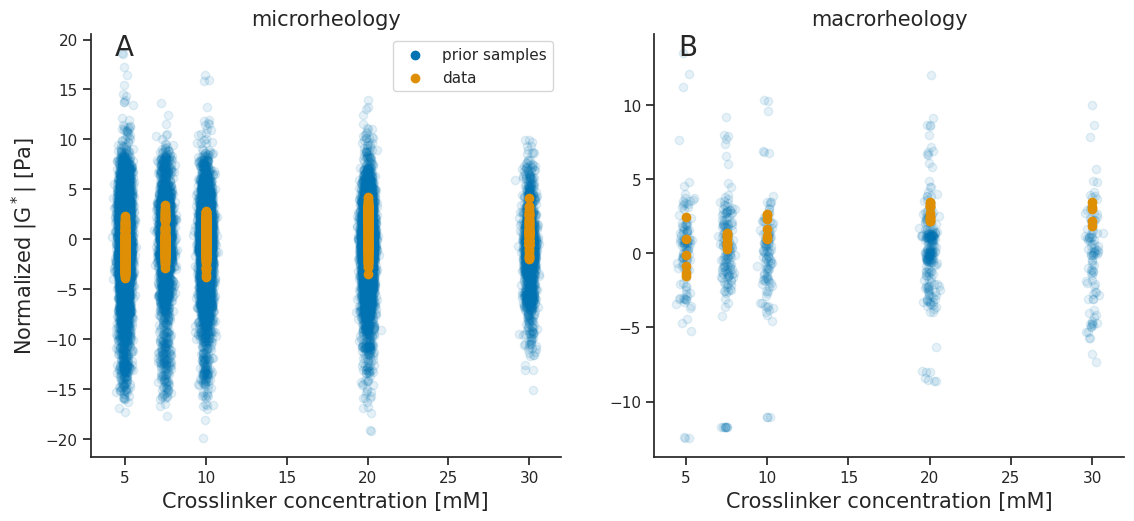

In [7]:
target = model.experimental_pin(likelihood=G,likelihood_macro=G_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model.sample(n_prior,seed=key)
prior_predictive(model,n_prior,crosslinker_raw,crosslinker,crosslinker_macro_raw,
                     crosslinker_macro,G,G_macro,units,naming,xlabel,mec_type,key)
states,log_probs = run_nuts(model.sample(seed=key),target,bijector,model,key)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


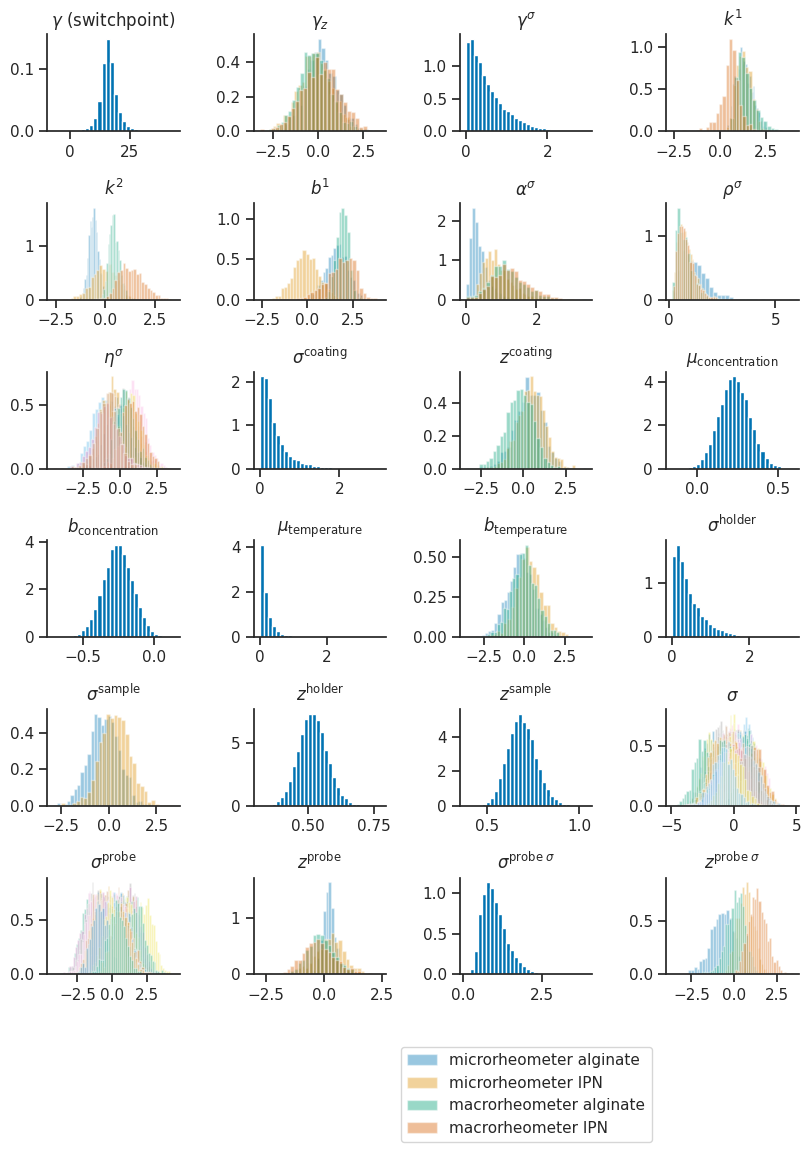

In [8]:
plot_posterior(jax.tree_util.tree_map(lambda x: jnp.squeeze(x),states),c_std,c_mean,'switchpoint','G')

Diagnostics

In [9]:
# rhat
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states))

StructTuple(
  switchpoint=0,
  switch_z=0,
  swtich_std=0,
  slope1=0,
  slope2=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  temperature_mu=0,
  concentration_std=0,
  concentration_z=0,
  temperature_std=0,
  temperature_z=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  warnings.warn(


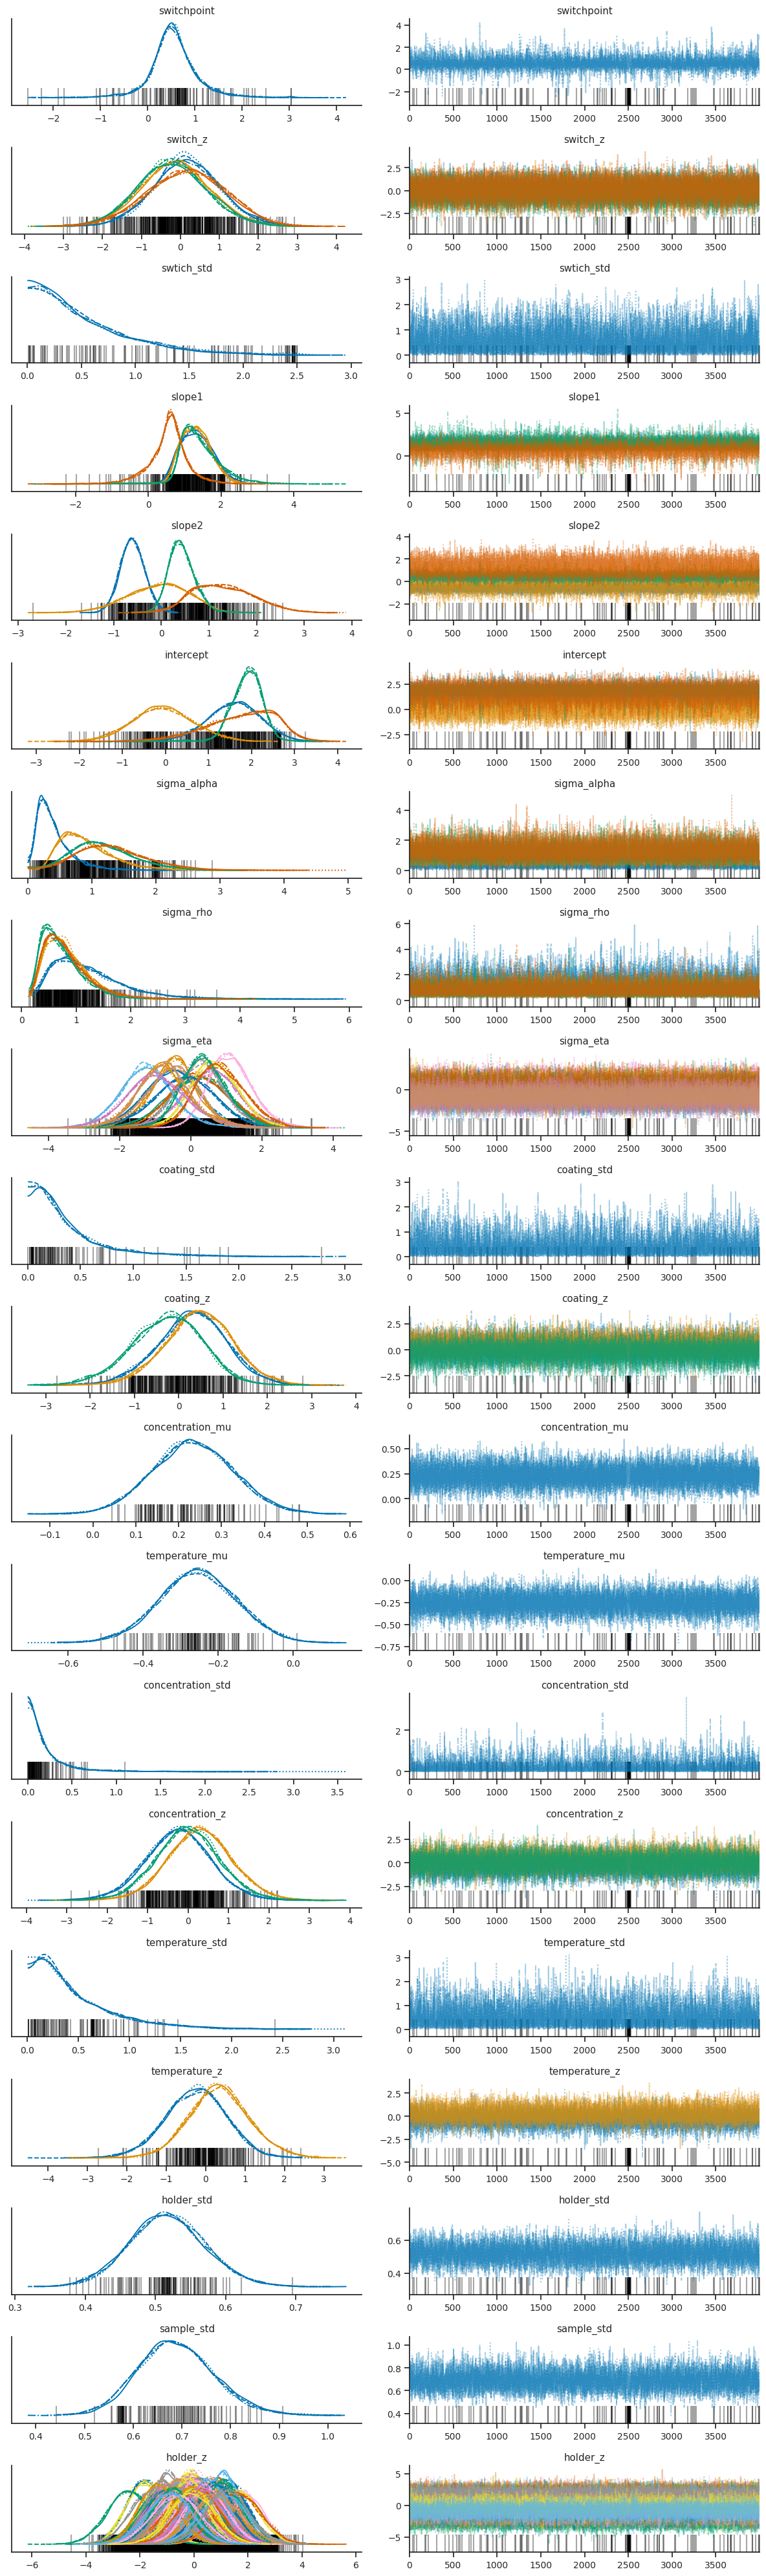

In [10]:
samps = gen_predictive(model,jax.tree_map(lambda x: jnp.squeeze(x),states))
trace = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states),log_probs,samps,radius_orig,coating_orig,temp_orig,concentration_orig,G_names,G_macro_names,G,G_macro,model_type)
ax = az.plot_trace(trace)
ax[0,0].figure.tight_layout()

In [11]:
summary = az.summary(trace,filter_vars='regex',var_names=['~eta']).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"])

alg 16.585806
ipn 15.439464
mac alg 15.122787
mac ipn 17.175087


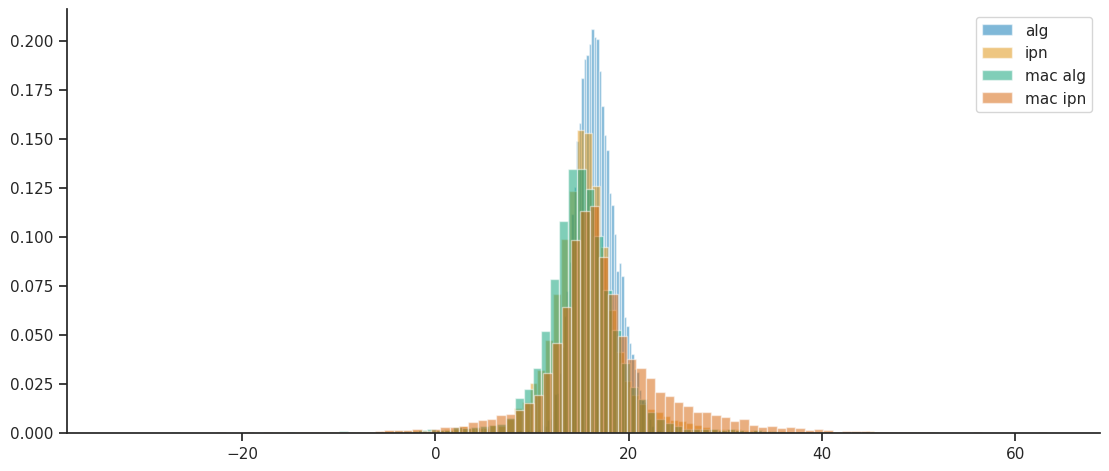

In [12]:
swithc_ef = einops.rearrange((states.switchpoint[...,None]+states.swtich_std[...,None]*states.switch_z[:,:,0,:]),'i j k -> (i j) k')*c_std+c_mean
na = ['alg','ipn','mac alg','mac ipn']
for i in range(swithc_ef.shape[-1]):
    _ = plt.hist(swithc_ef[:,i],bins=100,alpha=0.5,label=na[i],density=True)
    print(na[i],swithc_ef[:,i].mean())
plt.legend()

Text(0.5, 1.0, 'switchpoint')

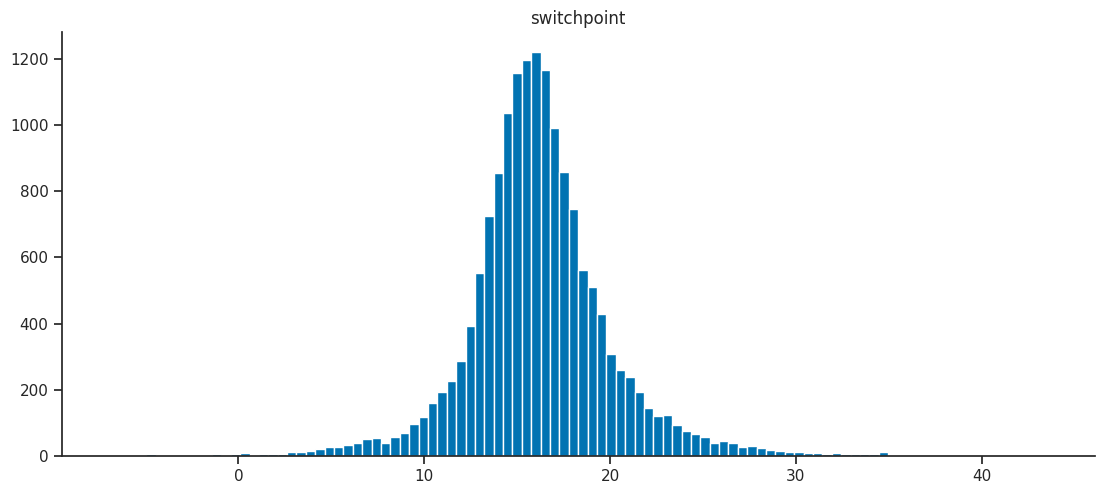

In [13]:
_ = plt.hist(states.switchpoint.ravel()*c_std+c_mean,bins=100)
plt.title('switchpoint')

In [14]:
def posterior_comparisons(data,macro,samps,states,crosslinker_macro_raw,crosslinker_raw,G,G_macro,xlabel,naming,units,mec_type):

    sub_sample = 100
    df1 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_raw,'G':G,'type':'data',
                    'material':data['type'].astype(pd.StringDtype()).reset_index()['type'],
                    'temperature':data['temp'].values,'concentration':data['concentration'].values}),
                pd.DataFrame({'G': einops.rearrange(np.array(samps.likelihood[::sub_sample]),'a b c -> (a b c)'),
                    'crosslinker':np.tile(crosslinker_raw,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                    'type':'model','material':np.tile(data['type'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                    'temperature':np.tile(data['temp'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                    'concentration':np.tile(data['concentration'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2]))})])

    df2 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_macro_raw,'G':G_macro,'type':'data',
                    'material':macro['type'].astype(pd.StringDtype()).reset_index()['type']}),
                pd.DataFrame({'G': einops.rearrange(np.array(samps.likelihood_macro[::sub_sample]),'a b c -> (a b c)'),
                    'crosslinker':np.tile(crosslinker_macro_raw,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                    'type':'model','material':np.tile(macro['type'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2]))})])
    
    fig,ax = plt.subplots(1,2)

    sns.violinplot(data=df1[(df1['material']=='alginate') & (df1['type']=='model')],x='crosslinker',
                y='G',ax=ax[0],color=sns.color_palette('colorblind')[0])
    sns.stripplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
                x='crosslinker',y='G',ax=ax[0],dodge=True,color='black')

    sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],x='crosslinker',
                   y='G',hue='concentration',ax=ax[1],palette=sns.color_palette('colorblind'))
    sns.stripplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
                x='crosslinker',y='G',hue='concentration',ax=ax[1],dodge=True,palette='dark:black',legend=False)

    ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units),fontsize=15)
    ax[1].set_ylabel('')
    ax[0].set_xlabel(xlabel,fontsize=15)
    ax[1].set_xlabel(xlabel,fontsize=15)
    ax[1].set_title('ipn',fontsize=15)
    ax[0].set_title('alginate',fontsize=15)
    fig.savefig(f'results/concentration_{mec_type}.png',bbox_inches = 'tight',dpi=600)

    fig,ax = plt.subplots(1,2)

    sns.violinplot(data=df1[(df1['material']=='alginate') & (df1['type']=='model')],x='crosslinker',
                y='G',ax=ax[0],color=sns.color_palette('colorblind')[0])
    sns.stripplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
                x='crosslinker',y='G',ax=ax[0],dodge=True,color='black')

    sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],
                   x='crosslinker',y='G',hue='temperature',ax=ax[1],
                   palette=sns.color_palette('colorblind'))
    sns.stripplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
                x='crosslinker',y='G',hue='temperature',ax=ax[1],dodge=True,palette='dark:black',legend=False)

    ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units),fontsize=15)
    ax[1].set_ylabel('')
    ax[0].set_xlabel(xlabel,fontsize=15)
    ax[1].set_xlabel(xlabel,fontsize=15)
    ax[1].set_title('ipn',fontsize=15)
    ax[0].set_title('alginate',fontsize=15)
    fig.savefig(f'results/temperature_{mec_type}.png',bbox_inches = 'tight',dpi=600)

    fig,ax = plt.subplots(1,2)
    sns.violinplot(data=df1[(df1['material']=='alginate') & (df1['type']=='model')],x='crosslinker',y='G',
                ax=ax[0],color=sns.color_palette('colorblind')[0])
    sns.stripplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
                x='crosslinker',y='G',ax=ax[0],color='black')
    sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y='G',
                ax=ax[1],palette=sns.color_palette('colorblind'))
    sns.stripplot(data=df2[(df2['material']=='alginate') & (df2['type']=='data')],
                x='crosslinker',y='G',ax=ax[1],color='black')

    ax[0].set_title('Microrheology')
    ax[1].set_title('Macrorheology')
    ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
    ax[1].set_ylabel('')
    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)
    fig.suptitle('alginate')

    fig.savefig(f'results/posterior_alginate_{mec_type}.png',bbox_inches = 'tight',dpi=600)


    fig,ax = plt.subplots(1,2)
    sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],x='crosslinker',y='G',
                ax=ax[0],color=sns.color_palette('colorblind')[0])
    sns.stripplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
                x='crosslinker',y='G',ax=ax[0],color='black')
    sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model')],x='crosslinker',y='G',
                ax=ax[1],palette=sns.color_palette('colorblind'))
    sns.stripplot(data=df2[(df2['material']=='ipn') & (df2['type']=='data')],
                x='crosslinker',y='G',ax=ax[1],color='black')

    ax[0].set_title('Microrheology')
    ax[1].set_title('Macrorheology')
    ax[0].set_ylabel(r'Normalized ${}$ [{}]'.format(naming,units))
    ax[1].set_ylabel('')
    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)
    fig.suptitle('ipn')

    fig.savefig(f'results/comparison_{mec_type}.png',bbox_inches = 'tight',dpi=600)

/tmp/ipykernel_29813/1958003193.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],x='crosslinker',
/tmp/ipykernel_29813/1958003193.py:46: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],
/tmp/ipykernel_29813/1958003193.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y='G',
/tmp/ipykernel_29813/1958003193.py:65: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y

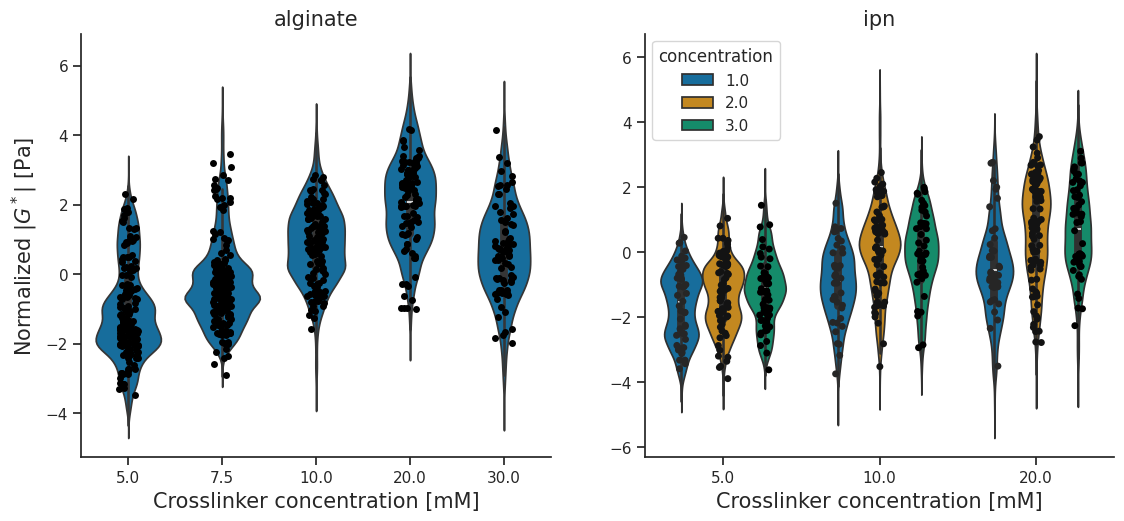

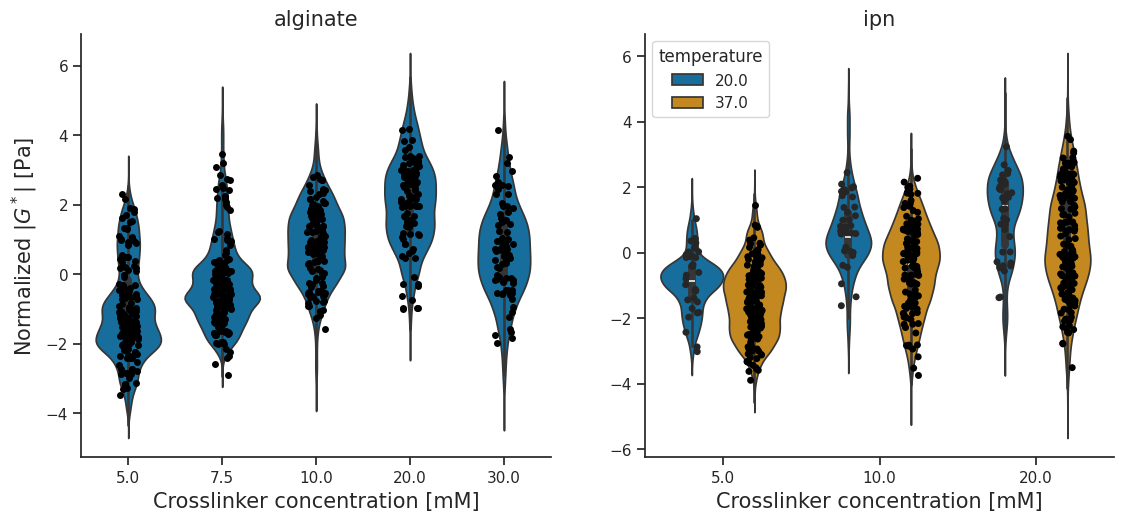

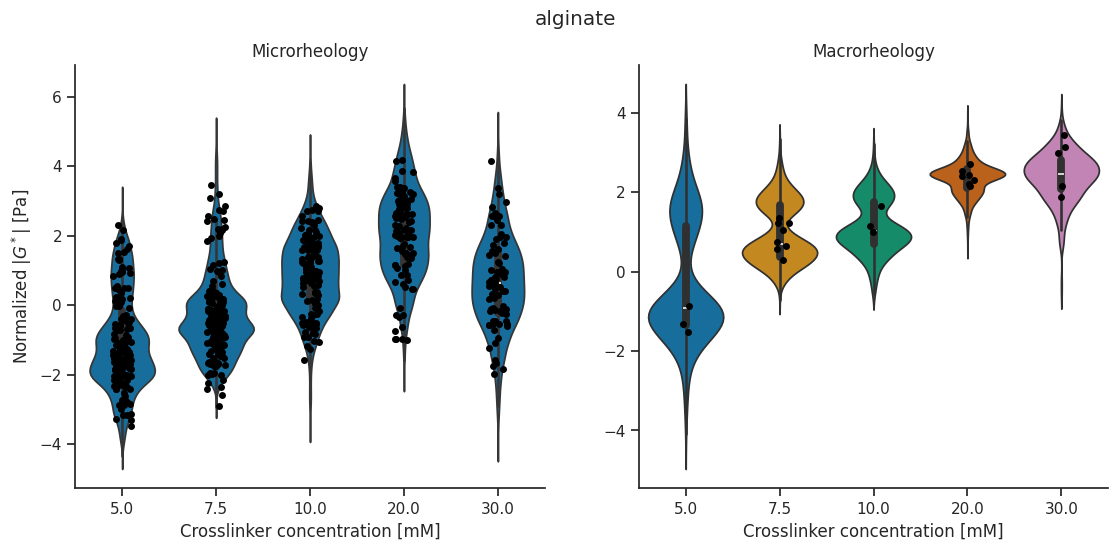

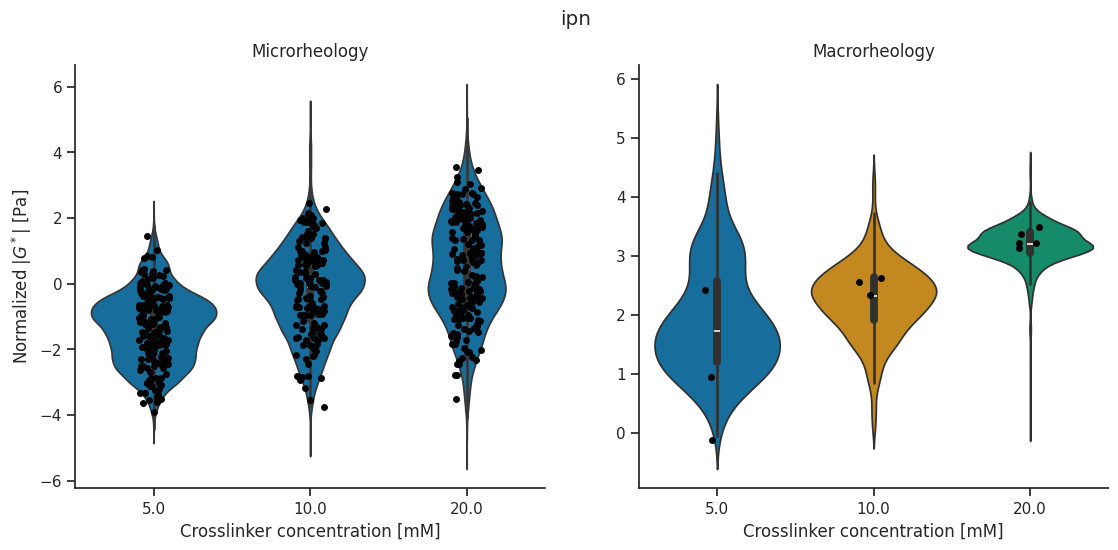

In [15]:
posterior_comparisons(data,macro,samps,states,crosslinker_macro_raw,crosslinker_raw,G,G_macro,xlabel,naming,units,mec_type)

Generate posterior predictive and draw results

In [16]:
N_pred = 100
c_pred = jnp.linspace(crosslinker.min(),crosslinker.max(),N_pred)

m1 = jnp.concatenate([np.zeros(N_alg),np.ones(N_ipn)]).astype(int)
m2 = jnp.concatenate([np.zeros(N_macro_alg),np.ones(N_macro_ipn)]).astype(int)+2

m1_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),np.ones(N_ipn),np.ones(N_pred)]).astype(int)

m2_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),
                       np.ones(N_ipn),np.ones(N_pred),
                       np.zeros(N_macro_alg),np.zeros(N_pred),
                       np.ones(N_macro_ipn),np.ones(N_pred)]).astype(int)

Compare macro to micro

In [17]:
from functools import partial
from models import rbf
import jax.nn as jnn

def mean_predictions(states,cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,cross_unique,
                     N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type):

    eta_key,sigma_eta_key = jr.split(key,2)
    #N_samples = states.eta.shape[0]
    num_c = states.sigma_alpha.shape[1]
    sub_sample = 3
    N_samples = states.sigma_rho[::sub_sample].shape[0]

    combined_alg = jnp.concatenate([cross_unique_alg,c_pred])
    combined_ipn = jnp.concatenate([cross_unique_ipn,c_pred])

    combined_macro_alg = jnp.concatenate([cross_unique_macro_alg,c_pred])
    combined_macro_ipn = jnp.concatenate([cross_unique_macro_ipn,c_pred])

    N_combined_alg = combined_alg.shape[0]
    N_combined_ipn = combined_ipn.shape[0]

    N_split = N_combined_alg+N_combined_ipn

    N_combined_macro_alg = combined_macro_alg.shape[0]
    N_combined_macro_ipn = combined_macro_ipn.shape[0]

    N_both = N_combined_alg+N_combined_ipn+N_combined_macro_alg+N_combined_macro_ipn

    if model_type=='switchpoint':
        slope1 = states.slope1[::sub_sample,:][...,None]
        slope2 = states.slope2[::sub_sample,:][...,None]
        #switchpoint = states.switchpoint[::sub_sample,:,:][...,None]
        switchpoint = states.switchpoint[::sub_sample,:][...,None]
        switch_std = states.swtich_std[::sub_sample,:][...,None]
        switch_z = states.switch_z[::sub_sample]
        intercept = states.intercept[::sub_sample,:][...,None]
        #switch = switchpoint[...,None]
        switch = (switchpoint+switch_std*switch_z)[...,None]
        #switch = switchpoint[:,:,[0,0,1,1]]
        #switch = tfb.Shift((20-c_mean)/c_std).forward(switchpoint)[:,:,[0,0,1,1]]
        i2 = (slope2*switch+intercept)-slope1*switch
        slope = slope2+sigmoid(switch-c_pred[None,None,None,...],10)*(slope1-slope2)
        inter = intercept+sigmoid(switch-c_pred[None,None,None,...],10)*(i2-intercept)
        curve = slope*c_pred[None,None,None,...]+inter

        slope_datapoints = slope2+sigmoid(switch-cross_unique[None,None,None,...],10)*(slope1-slope2)
        inter_datapoints = intercept+sigmoid(switch-cross_unique[None,None,None,...],10)*(i2-intercept)
        curve_datapoints = slope_datapoints*cross_unique[None,None,None,...]+inter_datapoints
    else:
        slope1 = states.slope1[::sub_sample,:][...,None]
        intercept = states.intercept[::sub_sample,:][...,None]
        curve = slope1*c_pred[None,None,None,...]+intercept
        curve_datapoints = slope1*cross_unique[None,None,None,...]+intercept


    eta_pred_sigma = jr.normal(sigma_eta_key,(*states.sigma_eta.shape[:2],N_pred))
    eta_both_sigma = jnp.dstack([states.sigma_eta[...,:N_alg],eta_pred_sigma,
                                states.sigma_eta[...,N_alg:(N_alg+N_ipn)],eta_pred_sigma,
                                states.sigma_eta[...,N_micro:(N_micro+N_macro_alg)],eta_pred_sigma,
                                states.sigma_eta[...,(N_micro+N_macro_alg):((N_micro+N_macro_alg+N_macro_ipn))],eta_pred_sigma])


    N_total_sigma = eta_both_sigma.shape[-1]

    K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(
                    # micro
                    einops.rearrange(jax.vmap(partial(rbf,combined_alg[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),

                    einops.rearrange(jax.vmap(partial(rbf,combined_ipn[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),
                    # macro
                    einops.rearrange(jax.vmap(partial(rbf,combined_macro_alg[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,2],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,2],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),
                    
                    einops.rearrange(jax.vmap(partial(rbf,combined_macro_ipn[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,3],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,3],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_both)[None,None,...]*(1e-4)

    L_K_sigma = jnp.linalg.cholesky(K_sigma)

    sigma = jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,eta_both_sigma[::sub_sample])+states.sigma_mu[::sub_sample,:,m2_])
    curve_datapoints = einops.rearrange(curve_datapoints,'i j k n -> (i j) k n')
    return curve,curve_datapoints,sigma,N_split

In [18]:
curve,curve_datapoints,sigma,N_split = mean_predictions(jax.tree_map(lambda x: jnp.squeeze(x),states),cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,
                            cross_unique_macro_ipn,cross_unique,
                            N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type)


Is macro larger than micro?

In [19]:
# rope
g_rope = G.std()*0.1

In [20]:
# alginate
print(((curve_datapoints[:,2]-curve_datapoints[:,0])>g_rope).sum()/np.prod(curve_datapoints[:,2].shape)*100)
# ipn
print(((curve_datapoints[:,3]-curve_datapoints[:,1])>g_rope).sum()/np.prod(curve_datapoints[:,2].shape)*100)

96.43928
99.996254


Is macro larger than micro (at different crosslinker values)

In [21]:
def micromacro_diff(x,i,j,label,g_rope):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1

    print(label,(diff>g_rope).sum(axis=0)/diff.shape[0]*100)
# 5,7.5,10,20,30 crosslinker
micromacro_diff(curve_datapoints,0,2,'alginate',g_rope)
micromacro_diff(curve_datapoints,1,3,'ipn',g_rope)

alginate [ 91.04198  95.40855  96.47676  99.26912 100.     ]
ipn [100.      100.      100.      100.       99.98126]


Blue is alginate, orange is IPN. Upper image is microrheometer, bottom is macrorheometer

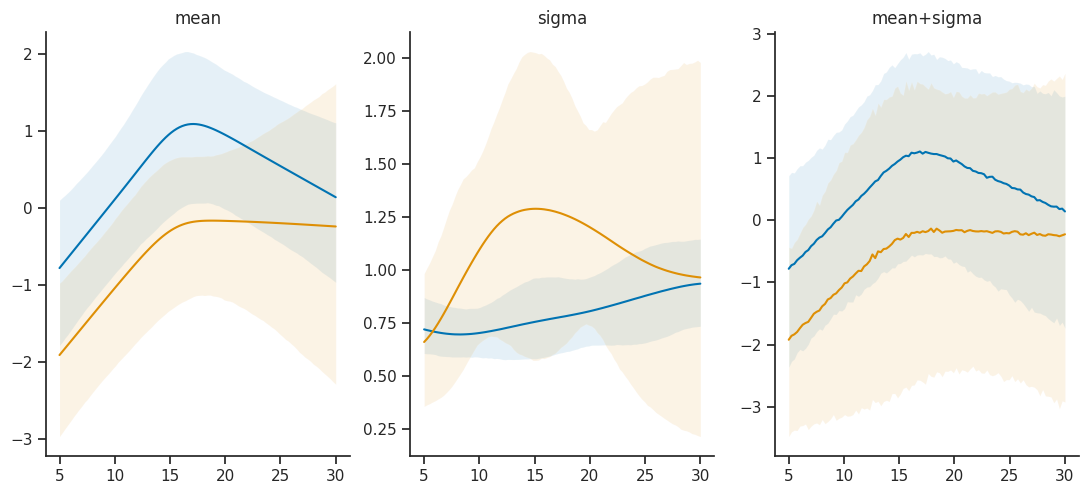

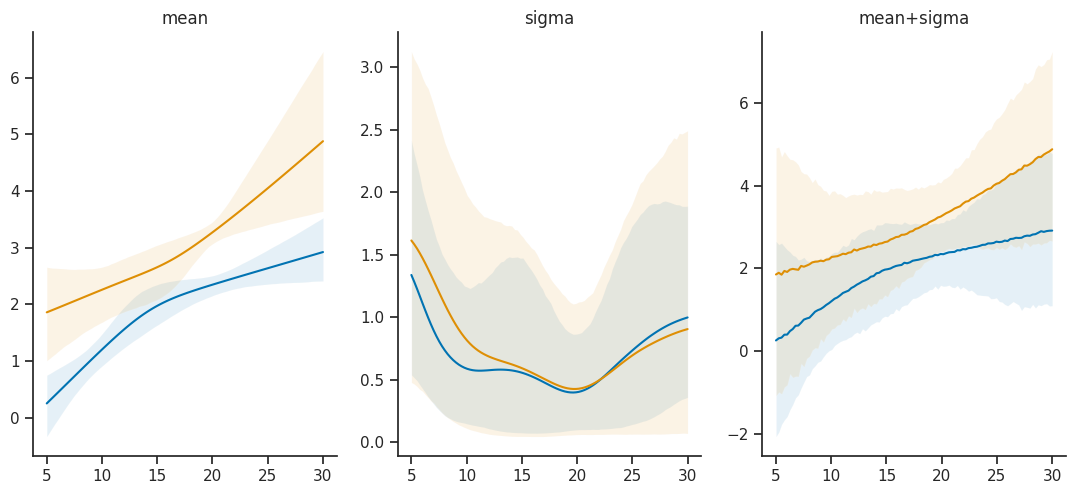

In [22]:
plot_mean(c_pred,c_std,c_mean,curve,sigma,N_alg,N_pred,N_ipn,N_split,N_macro_alg,
              N_macro_ipn)

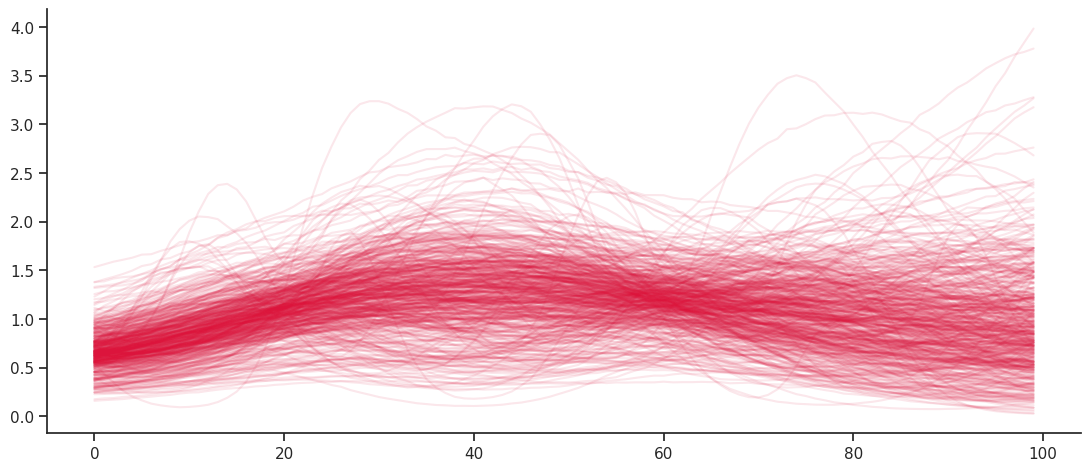

In [23]:
_ = plt.plot(np.reshape(sigma[:,:,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)],(-1,100))[::10].T,color='crimson',alpha=0.1)

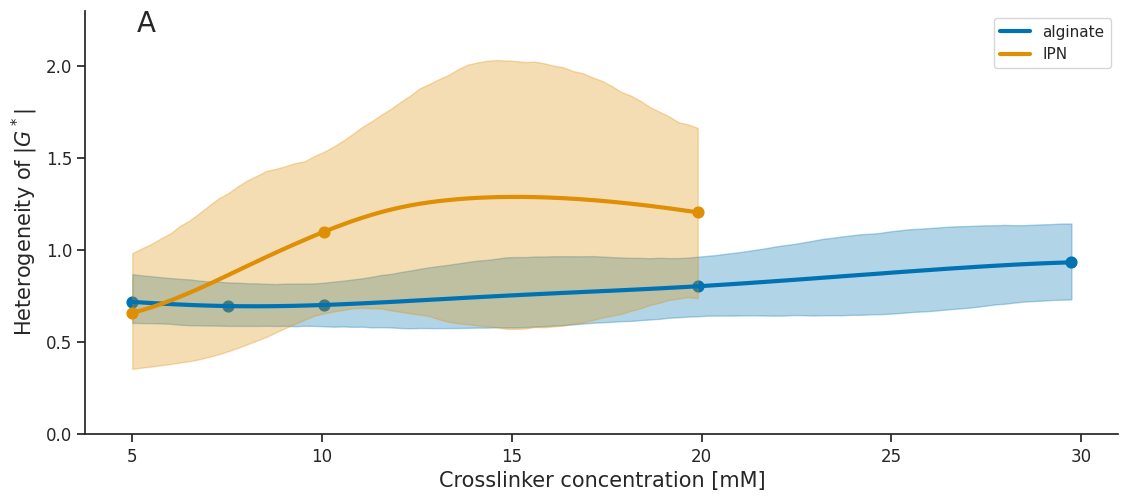

In [24]:
plot_heterogeneity(N_alg,N_ipn,N_pred,c_pred,crosslinker,type_indices,sigma,c_std,c_mean,naming,units,xlabel,mec_type)

How does model heterogeneity relate to data std?

In [25]:
from functools import partial
from models import rbf
import jax.nn as jnn

def gen_sigma_data(states):
        sub_sample = 1
        N_samples = states.sigma_rho[::sub_sample].shape[0] 
        num_c = states.sigma_alpha.shape[1]
        K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(einops.rearrange(jax.vmap(partial(rbf,cross_unique_alg[...,None]))(
                        einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                        einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                        '(n c) a b -> n c a b',n=N_samples,c=num_c),
                einops.rearrange(jax.vmap(partial(rbf,cross_unique_ipn[...,None]))(
                        einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                        einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                        '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_micro)[None,None,...]*(1e-5)


        L_K_sigma = jnp.linalg.cholesky(K_sigma)
        sigma_data = einops.rearrange(jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,states.sigma_eta[::sub_sample,:,:N_micro])+states.sigma_mu[::sub_sample,:,m1]),
                                'a b c -> (a b) c')
        return sigma_data
                        

/tmp/ipykernel_29813/1138600771.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat = data.groupby(['type','crosslinker']).std()[['G_abs_norm']].reset_index()


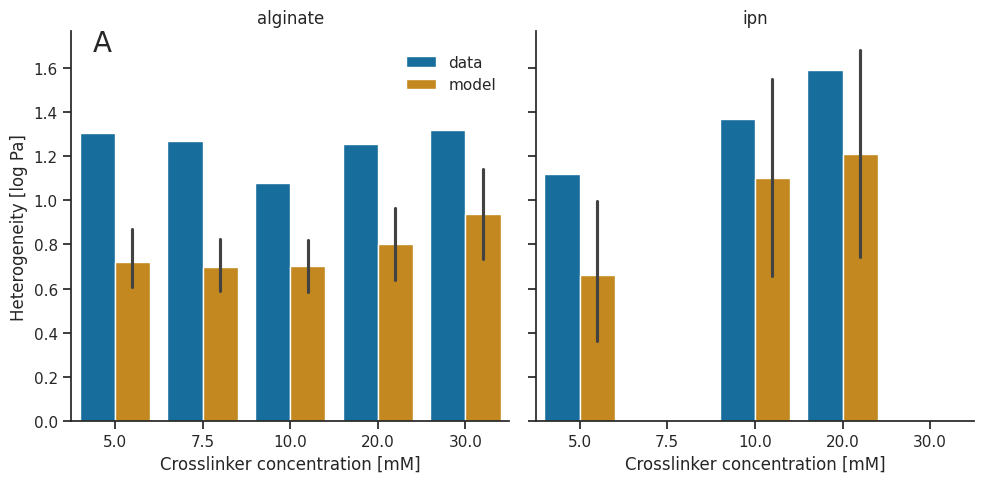

In [26]:
sigma_mean = gen_sigma_data(states)
m_df = pd.DataFrame(gen_sigma_data(states),
             columns=[*[f'alginate_{i}' for i in [5.,7.5,10.,20.,30.]],*[f'ipn_{i}' for i in [5.,10.,20.]]]).melt(var_name='crosslinker',value_name='heterogeneity')
m_df[['material','crosslinker']] = m_df['crosslinker'].str.split('_',expand=True)
#m_df = pd.DataFrame(sigma_mean,columns=['heterogeneity'])
m_df['type'] = 'model'

data['G_abs_norm'] = (np.log(data['G_abs']))
dat = data.groupby(['type','crosslinker']).std()[['G_abs_norm']].reset_index()
dat.columns = ['material','crosslinker','heterogeneity']
dat['type'] = 'data'

comb = pd.concat([dat,m_df])
g = sns.catplot(data=comb,col='material',x='crosslinker',y='heterogeneity',
            hue='type',kind='bar',sharey=True,margin_titles=False,palette=[*sns.color_palette('colorblind')[:2]],
            legend_out=False,errorbar=lambda x: (np.percentile(x,5),np.percentile(x,95)))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.legend.set_title('')
sns.move_legend(g,'upper left',frameon=False,bbox_to_anchor=(.4, .9))
g.set_xlabels(xlabel)
g.set_ylabels('Heterogeneity [log Pa]')
g.axes[0][0].text(0.05, 0.95, 'A', transform=g.axes[0][0].transAxes,fontsize=20)
plt.savefig(f'results/heterogeneity_discrete.png',bbox_inches = 'tight',dpi=600)

Slope being positive (before switchpoint)

In [27]:
states.holder_std.mean()+states.sample_std.mean()

Array(1.2060218, dtype=float32)

In [28]:
np.log(macro['Complex Shear Modulus']).std()

1.3179384452215375

In [29]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
for k in [jnp.squeeze(states.slope1),jnp.squeeze(states.slope2)]:
    ee = einops.rearrange(k, 'i j l -> (i j) l')
    for i,j in zip(range(ee.shape[-1]),names):
        print(np.sum(ee[:,i]>g_rope)/ee[:,i].shape[0]*100)
    print('---')

99.94375
98.5375
98.23125
81.774994
---
0.17500001
37.925
84.0375
97.69375
---


Incrase in heterogeneity (comparing individual points)

In [30]:
increase_in_heterogeneity(states,cross_unique_alg,cross_unique_ipn,N_micro,c_std,
                              c_mean,N_alg,N_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,
                              N_macro,N_macro_alg,N_macro_ipn,m1,m2)

alginate 10.0 20.0 49.19  
alginate 10.0 30.0 88.78  
alginate 20.0 30.0 61.26  
alginate 5.0 10.0 2.27  
alginate 5.0 20.0 42.29  
alginate 5.0 30.0 82.05  
alginate 5.0 7.5 0.04  
alginate 7.5 10.0 2.81  
alginate 7.5 20.0 50.93  
alginate 7.5 30.0 87.94  
ipn 10.0 20.0 51.59  
ipn 5.0 10.0 99.84 *** 
ipn 5.0 20.0 99.98 **** 


Where does the saturationa approximately start (for alginate)

16.154646


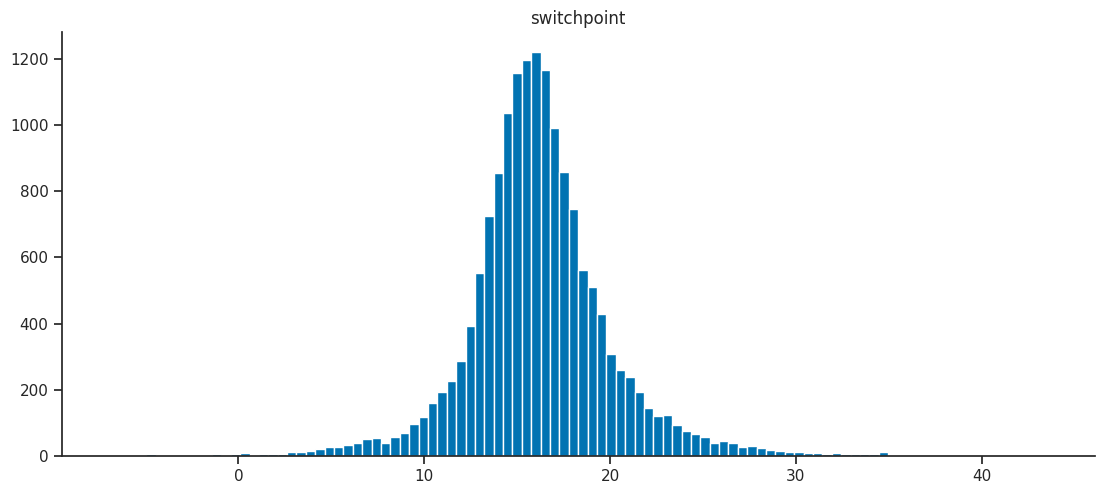

In [31]:
switchpoint = np.array(states.switchpoint.ravel())*c_std+c_mean
_ = plt.hist(switchpoint,bins=100)
plt.title('switchpoint')
print(np.mean(switchpoint))

# $\Phi$

In [32]:
model_type = 'linear'
mec_type = 'phi'
naming = '\Phi'
units = 'rad'

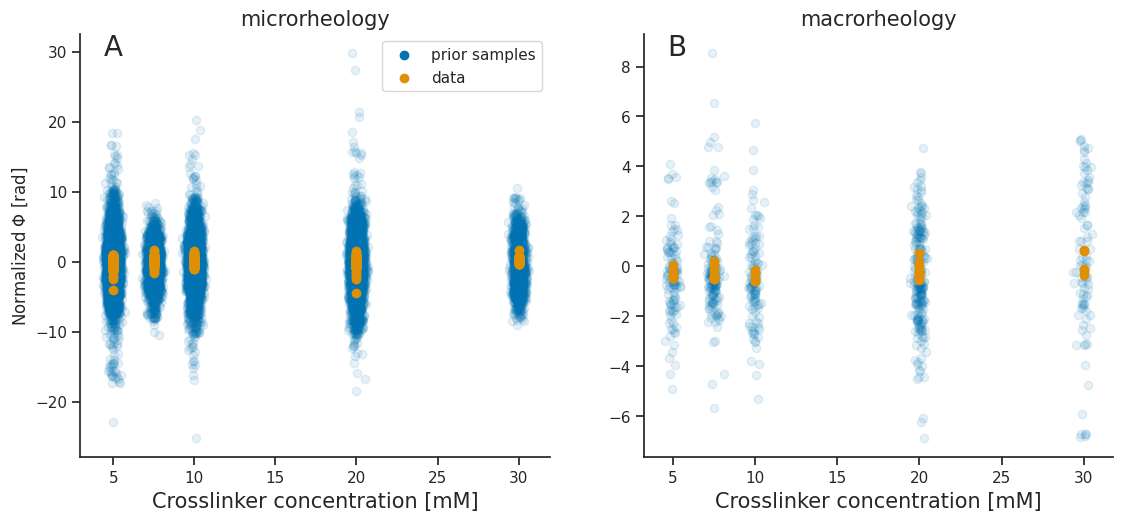

In [33]:
model_phi = gen_model(crosslinker,concentration,temperature,cross_all,c_mean,c_std,N,N_coating,N_holders,N_dat_samples,N_radius,\
              coating_indices,holder_indices,sample_indices,radius_indices,cross_unique_alg,cross_unique_ipn,\
              cross_unique_macro_alg,cross_unique_macro_ipn,micro_coords,indices_typed,micro_mu_indices,types,\
              macro_coords,indices_typed_macro,macro_mu_indices,concentration_indices,temp_indices,model_type)

target = model_phi.experimental_pin(likelihood=phi,likelihood_macro=phi_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model_phi.sample(n_prior,seed=key)
prior_predictive(model_phi,n_prior,crosslinker_raw,crosslinker,crosslinker_macro_raw,
                     crosslinker_macro,phi,phi_macro,units,naming,xlabel,mec_type,key)
states_phi,log_probs_phi = run_nuts(model_phi.sample(seed=key),target,bijector,model_phi,key)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


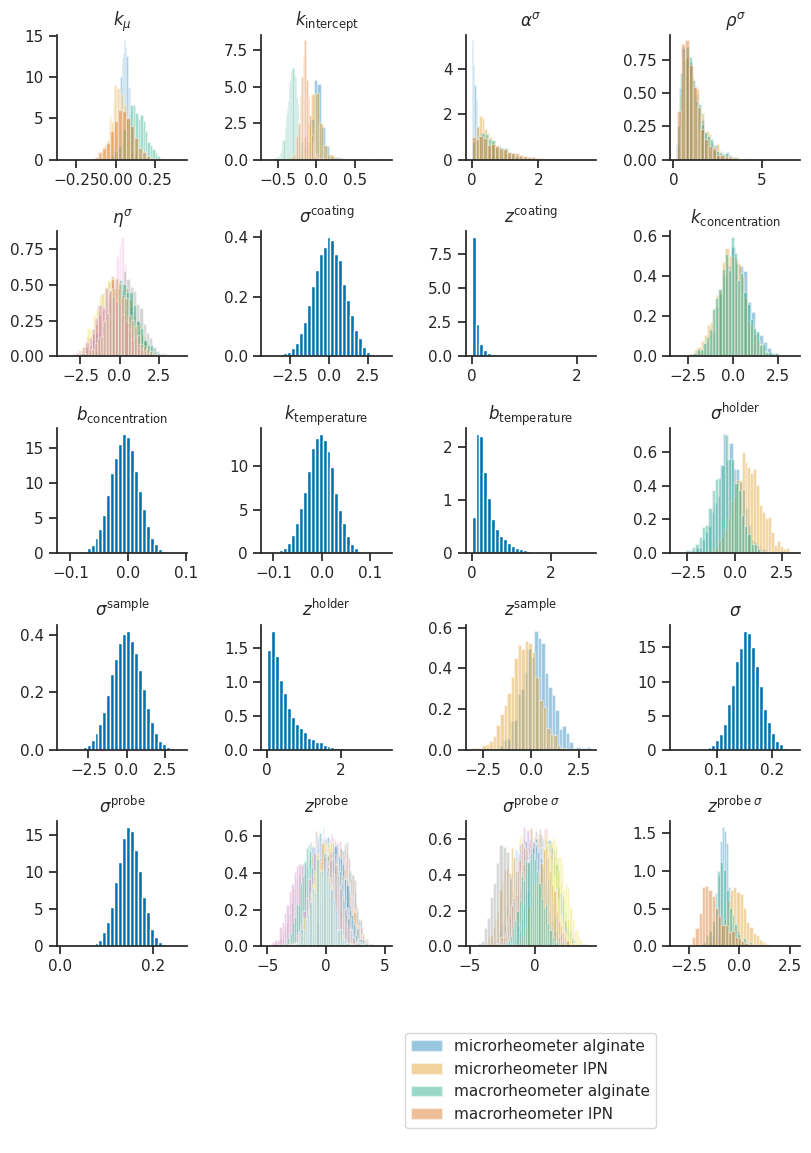

In [34]:
plot_posterior(jax.tree_util.tree_map(lambda x: jnp.squeeze(x),states_phi),c_std,c_mean,'linear',mec_type)

In [35]:
# rhat
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states_phi))

StructTuple(
  slope1=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_mu=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  temperature_mu=0,
  concentration_std=0,
  concentration_z=0,
  temperature_mu_sigma=0,
  temperature_std=0,
  temperature_z=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


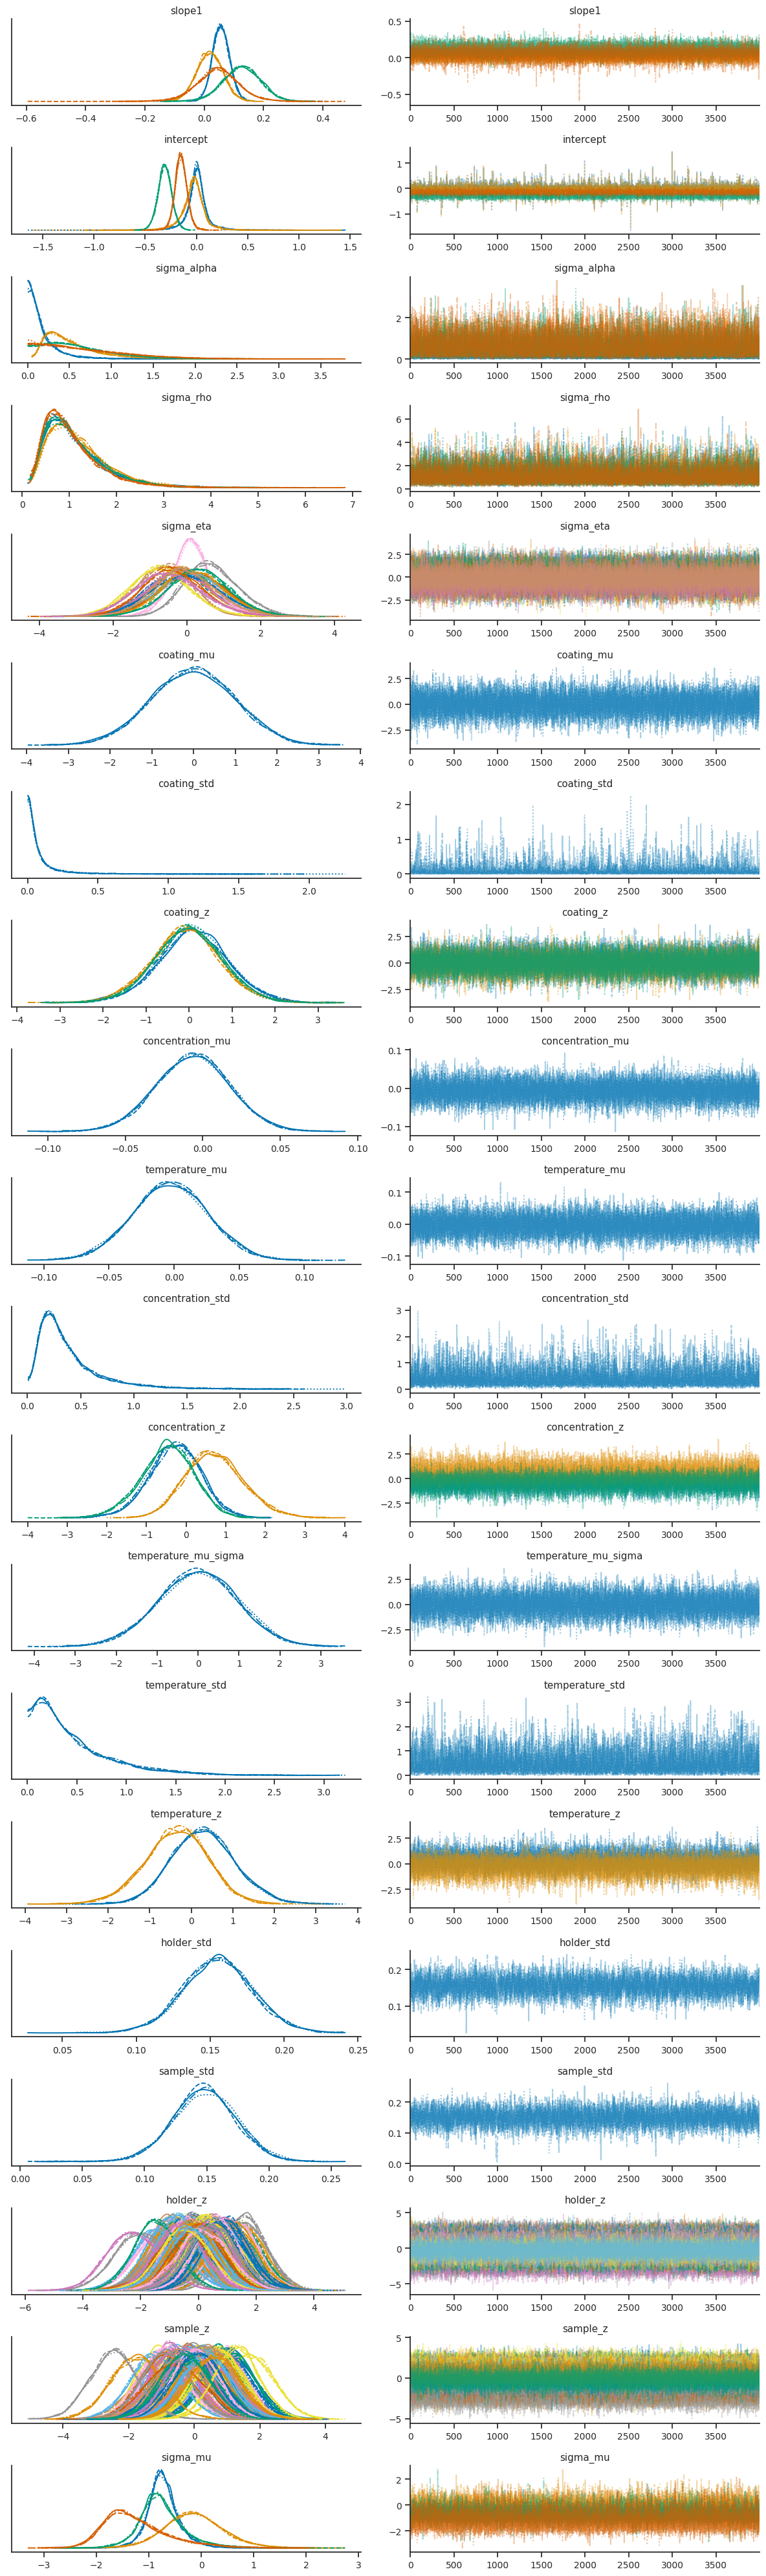

In [36]:
samps_phi = gen_predictive(model_phi,jax.tree_map(lambda x: jnp.squeeze(x),states_phi))
trace_phi = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),log_probs_phi,samps_phi,radius_orig,coating_orig,temp_orig,concentration_orig,G_names,G_macro_names,phi,phi_macro,model_type)
ax = az.plot_trace(trace_phi)
ax[0,0].figure.tight_layout()

In [37]:
summary_phi = az.summary(trace_phi,filter_vars='regex',var_names=['~eta']).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"])

/tmp/ipykernel_29813/1958003193.py:26: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],x='crosslinker',
/tmp/ipykernel_29813/1958003193.py:46: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df1[(df1['material']=='ipn') & (df1['type']=='model')],
/tmp/ipykernel_29813/1958003193.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y='G',
/tmp/ipykernel_29813/1958003193.py:65: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y

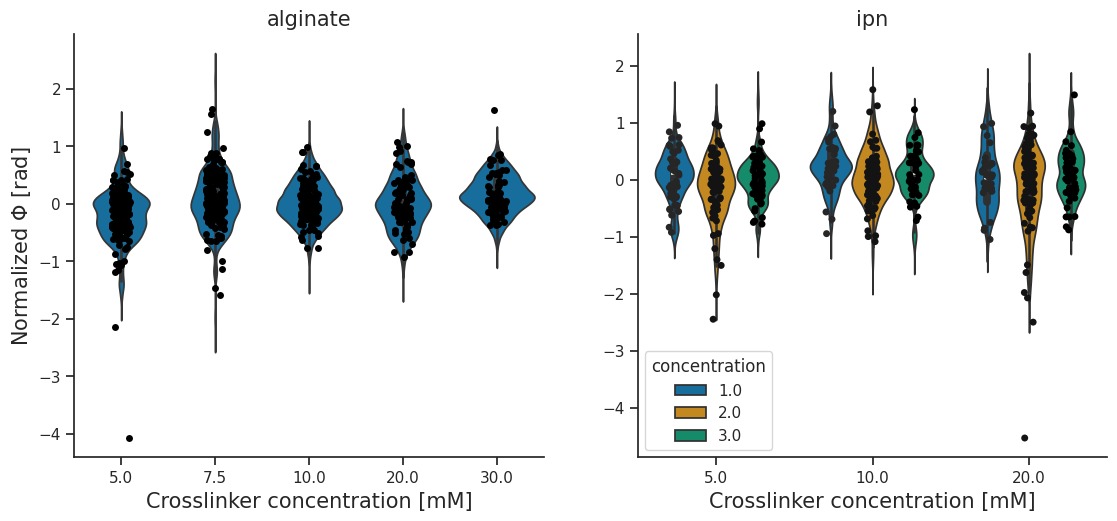

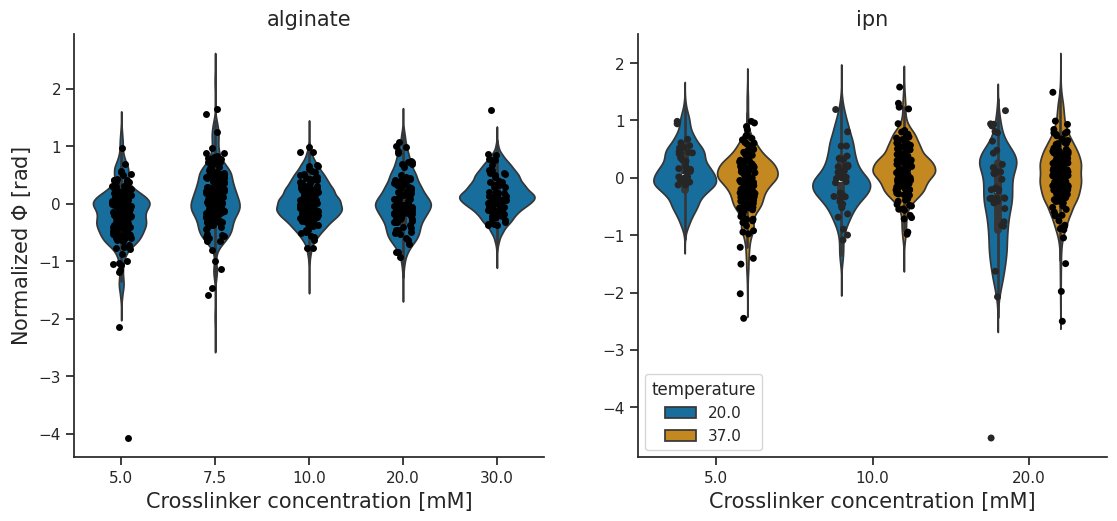

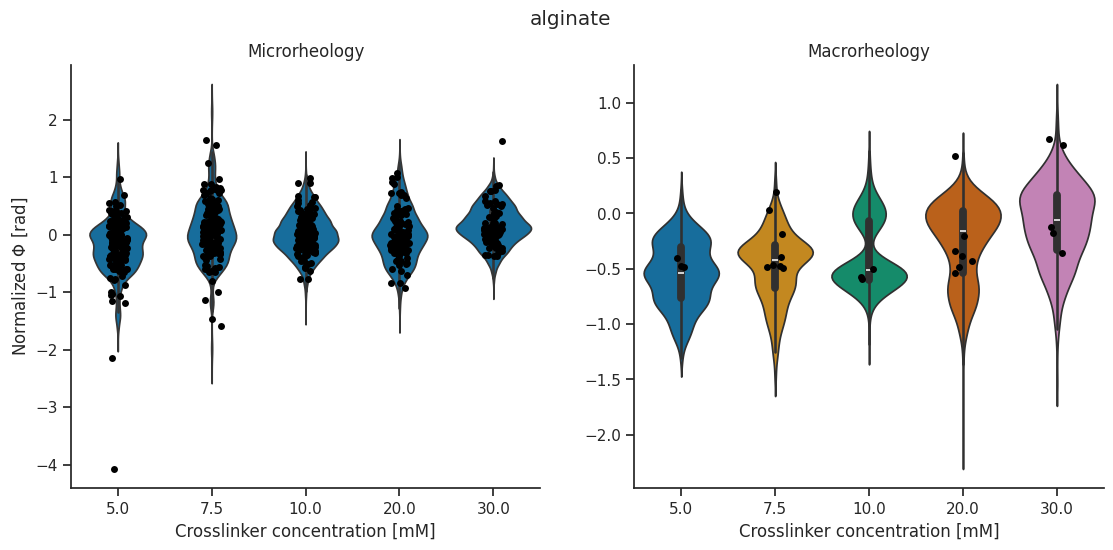

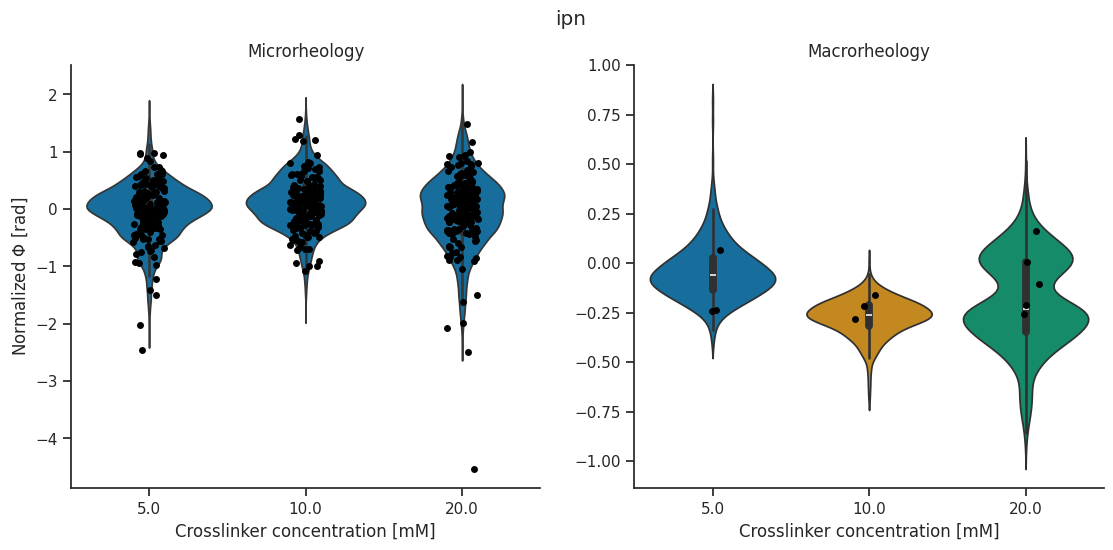

In [38]:
posterior_comparisons(data,macro,samps_phi,states_phi,crosslinker_macro_raw,crosslinker_raw,phi,phi_macro,xlabel,naming,units,mec_type)

is macro smaller than micro?

In [39]:
phi_rope = phi.std()*0.1

In [40]:
curve_phi,curve_datapoints_phi,sigma_phi,N_split = mean_predictions(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,
                            cross_unique_macro_ipn,cross_unique,
                            N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type)

print(((curve_datapoints_phi[:,2]-curve_datapoints_phi[:,0])<-phi_rope).sum()/np.prod(curve_datapoints_phi[:,2].shape)*100)
print(((curve_datapoints_phi[:,3]-curve_datapoints_phi[:,1])<-phi_rope).sum()/np.prod(curve_datapoints_phi[:,2].shape)*100)


90.85832
67.15892


In [41]:
def micromacro_diff(x,i,j,label):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1

    print(label,(diff<-0.1).sum(axis=0)/diff.shape[0]*100)
micromacro_diff(curve_datapoints_phi,0,2,'alginate')
micromacro_diff(curve_datapoints_phi,1,3,'ipn')

alginate [97.03898  96.73913  96.34558  85.49475  58.264618]
ipn [62.949776 62.050224 60.04498  46.53298  40.89205 ]


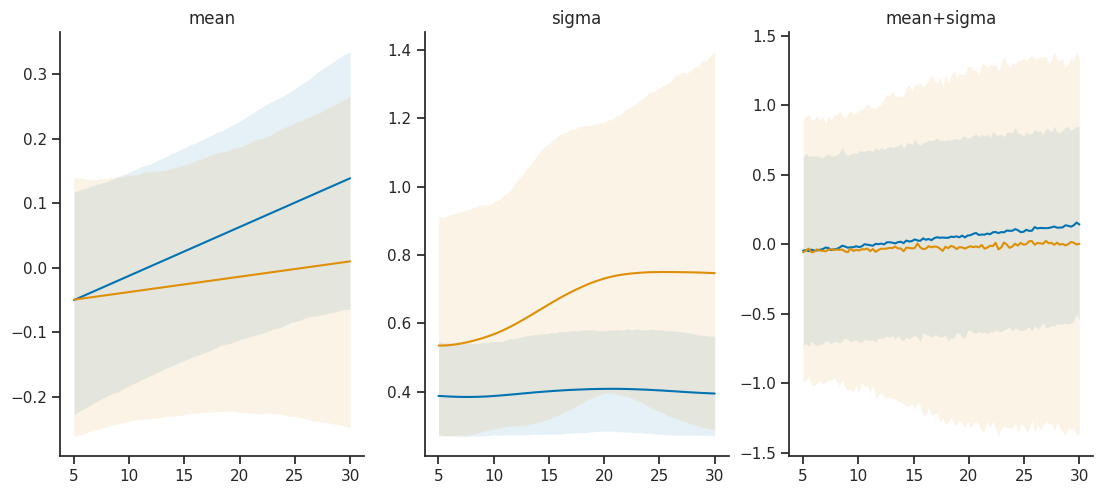

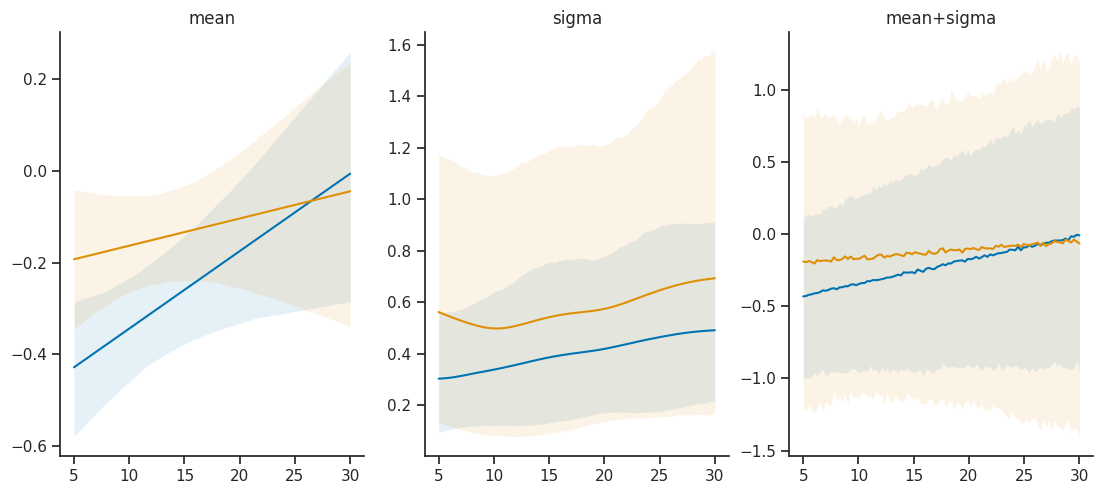

In [42]:
plot_mean(c_pred,c_std,c_mean,curve_phi,sigma_phi,N_alg,N_pred,N_ipn,N_split,N_macro_alg,
              N_macro_ipn)

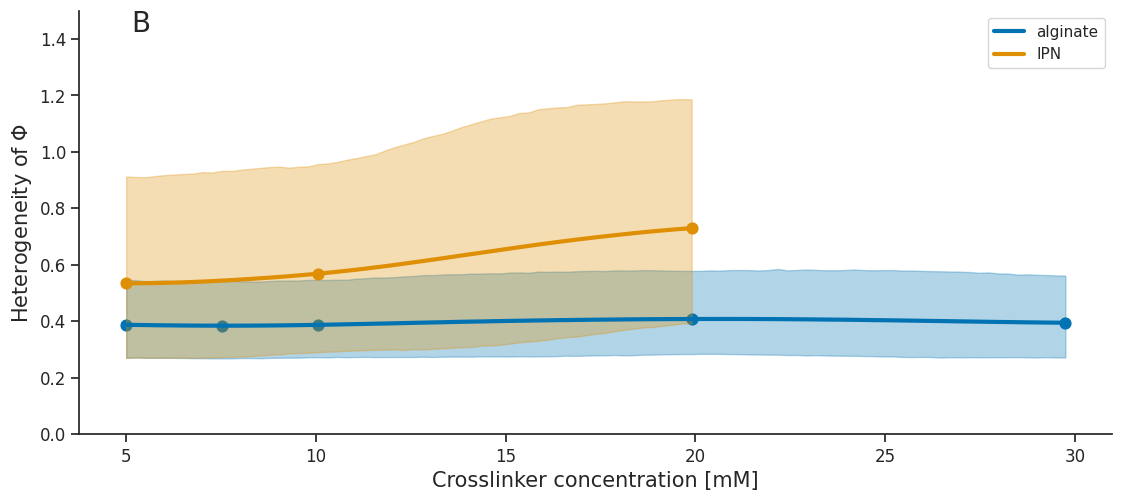

In [43]:
plot_heterogeneity(N_alg,N_ipn,N_pred,c_pred,crosslinker,type_indices,sigma_phi,c_std,c_mean,naming,units,xlabel,mec_type)

/tmp/ipykernel_29813/3416360303.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat = data.groupby(['type','crosslinker']).std()[['phi_norm']].reset_index()


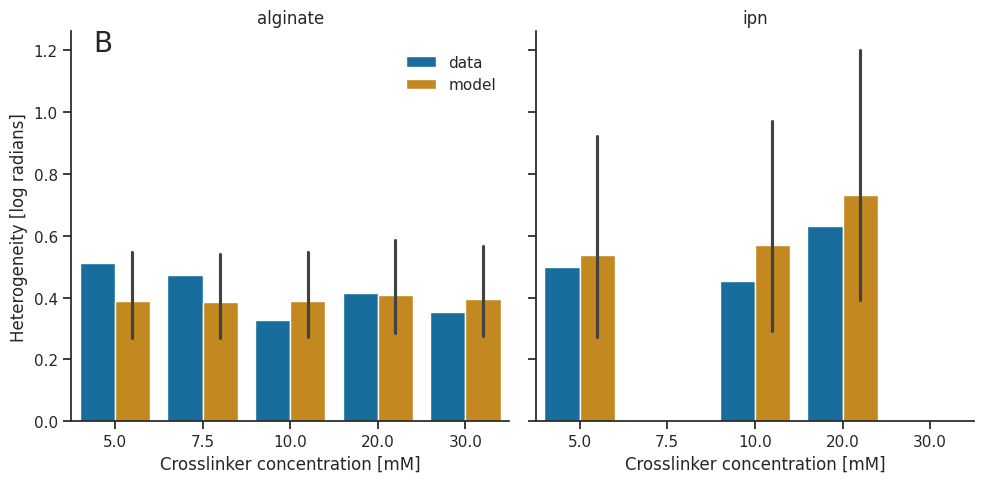

In [44]:
m_df = pd.DataFrame(gen_sigma_data(states_phi),
             columns=[*[f'alginate_{i}' for i in [5.,7.5,10.,20.,30.]],*[f'ipn_{i}' for i in [5.,10.,20.]]]).melt(var_name='crosslinker',value_name='heterogeneity')
m_df[['material','crosslinker']] = m_df['crosslinker'].str.split('_',expand=True)
#m_df = pd.DataFrame(sigma_mean,columns=['heterogeneity'])
m_df['type'] = 'model'

data['phi_norm'] = (np.log(data['phi_(rad)']))
dat = data.groupby(['type','crosslinker']).std()[['phi_norm']].reset_index()
dat.columns = ['material','crosslinker','heterogeneity']
dat['type'] = 'data'

comb = pd.concat([dat,m_df])
g = sns.catplot(data=comb,col='material',x='crosslinker',y='heterogeneity',
            hue='type',kind='bar',sharey=True,margin_titles=False,palette=[*sns.color_palette('colorblind')[:2]],
            legend_out=False,errorbar=lambda x: (np.percentile(x,5),np.percentile(x,95)))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.legend.set_title('')
sns.move_legend(g,'upper left',frameon=False,bbox_to_anchor=(.4, .9))
g.set_xlabels(xlabel)
g.set_ylabels('Heterogeneity [log radians]')
g.axes[0][0].text(0.05, 0.95, 'B', transform=g.axes[0][0].transAxes,fontsize=20)
plt.savefig(f'results/heterogeneity_discrete_phi.png',bbox_inches = 'tight',dpi=600)

In [45]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
for k in [jnp.squeeze(states_phi.slope1)]:
    ee = einops.rearrange(k, 'i j l -> (i j) l')
    for i,j in zip(range(ee.shape[-1]),names):
        print(np.sum(ee[:,i]>phi_rope)/ee[:,i].shape[0]*100)
    print('---')

59.6125
24.4375
89.2875
47.4875
---


In [46]:
increase_in_heterogeneity(states_phi,cross_unique_alg,cross_unique_ipn,N_micro,c_std,
                              c_mean,N_alg,N_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,
                              N_macro,N_macro_alg,N_macro_ipn,m1,m2)

alginate 10.0 20.0 3.42  
alginate 10.0 30.0 1.38  
alginate 20.0 30.0 0.1  
alginate 5.0 10.0 0.18  
alginate 5.0 20.0 5.54  
alginate 5.0 30.0 2.48  
alginate 5.0 7.5 0.0  
alginate 7.5 10.0 0.15  
alginate 7.5 20.0 5.72  
alginate 7.5 30.0 2.35  
ipn 10.0 20.0 85.74  
ipn 5.0 10.0 5.26  
ipn 5.0 20.0 93.38  


## Combined plots

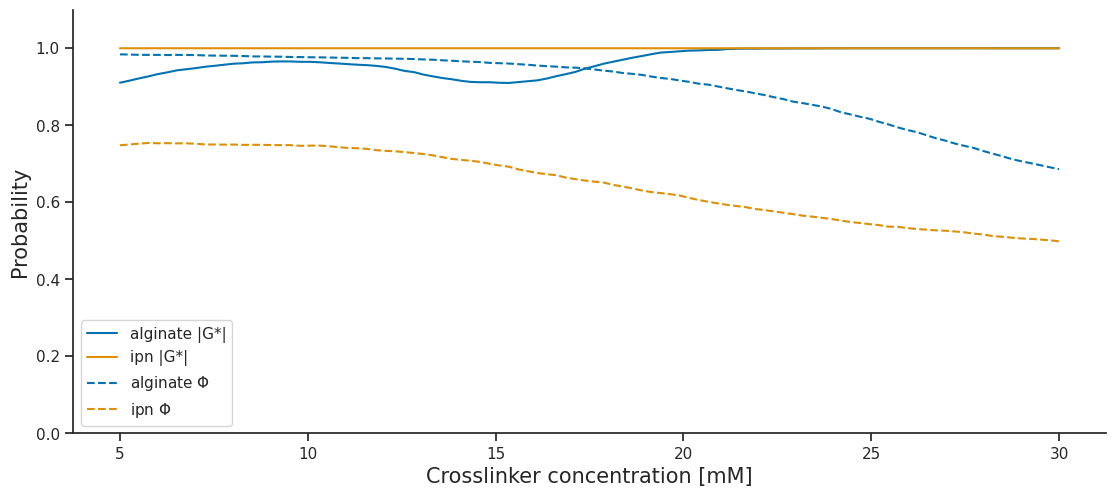

In [47]:
compare_micromacro(curve,curve_phi,c_pred,c_std,c_mean,xlabel,g_rope,phi_rope)

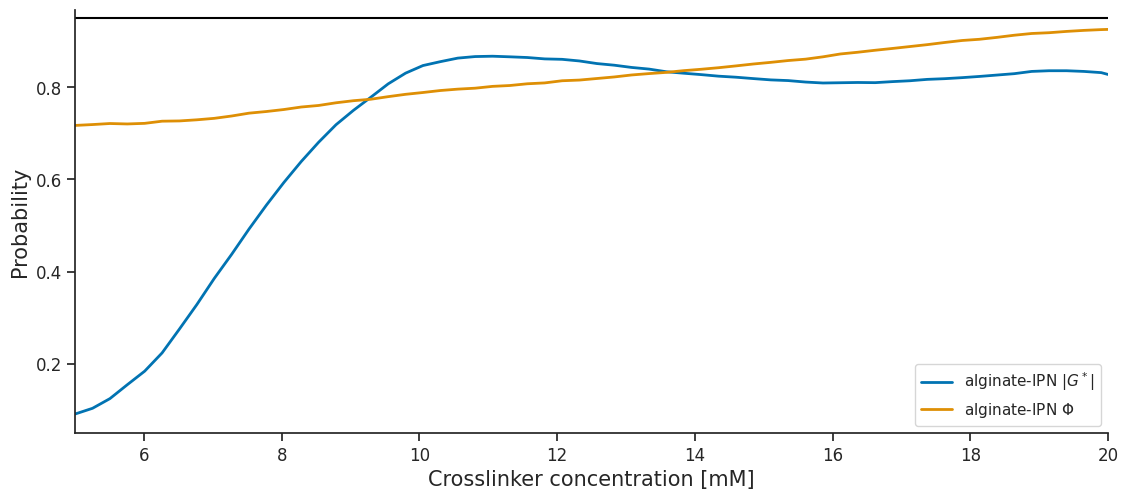

In [48]:
compare_heterogeneity(sigma,N_alg,N_pred,N_ipn,c_pred,c_std,c_mean,sigma_phi,xlabel,g_rope,phi_rope)

In [49]:
trace = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states),log_probs,samps,radius_orig,coating_orig,temp_orig,concentration_orig,G_names,G_macro_names,G,
G_macro,model_type,1)
trace_phi = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),log_probs_phi,samps_phi,radius_orig,coating_orig,temp_orig,concentration_orig,G_names,G_macro_names,phi,
phi_macro,model_type,1)

In [50]:
labeller = azl.MapLabeller(var_name_map={"radius_effect": "Magnetic probe ",
                                         "coating_effect": "Coating  ",
                                         "radius_sigma_effect": "Magnetic probe ",
                                         "temperature_sigma_effect": "Polymerization temperature ",
                                         "concentration_sigma_effect": "Collagen concentration ",
                                         "temperature_mu":"Polymerization temperature",
                                         "concentration_mu":"Collagen concentration",
                                         "holder_std": "Holder",
                                         "sample_std":"Sample"})

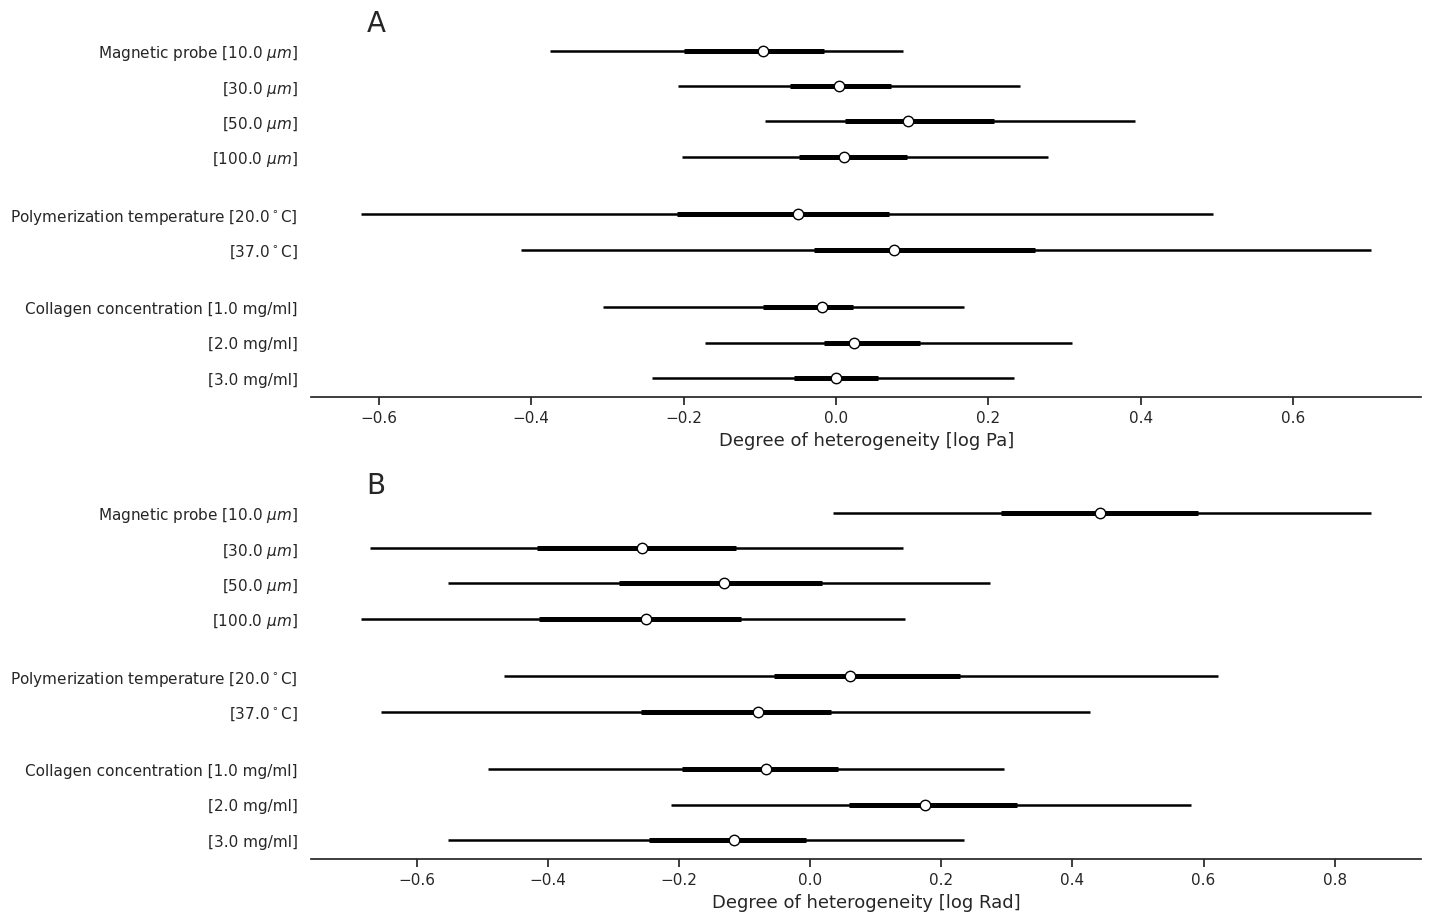

In [57]:
fig,ax = plt.subplots(2,1,figsize=(14.33,2*5.5))
ax[0] = az.plot_forest(trace,
                    var_names=['radius_sigma_effect','temperature_sigma_effect',
                               'concentration_sigma_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors='black',linewidth=1.8,
                    markersize=10,ax=ax[0],transform=lambda x:x)[0]

ax[1] = az.plot_forest(trace_phi,
                    var_names=['radius_sigma_effect','temperature_sigma_effect',
                               'concentration_sigma_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors='black',linewidth=1.8,
                    markersize=10,ax=ax[1],transform=lambda x:x)[0]
for a in ax.ravel():
    #a.axvline(0,color='black',alpha=0.1)
    a.set_title('')

ax[0].set_xlabel('Degree of heterogeneity [log Pa]',fontsize=13)
ax[1].set_xlabel('Degree of heterogeneity [log Rad]',fontsize=13)
ax[0].text(0.05, 0.95, 'A', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'B', transform=ax[1].transAxes,fontsize=20)
#ax[0].set_title(r'$|G^*|$',fontsize=15)
#ax[1].set_title(r'$\Phi$',fontsize=15)
fig.savefig(f'results/heterogeneity_effects.png',bbox_inches = 'tight',dpi=600)

Text(0.5, 1.0, '$\\Phi$')

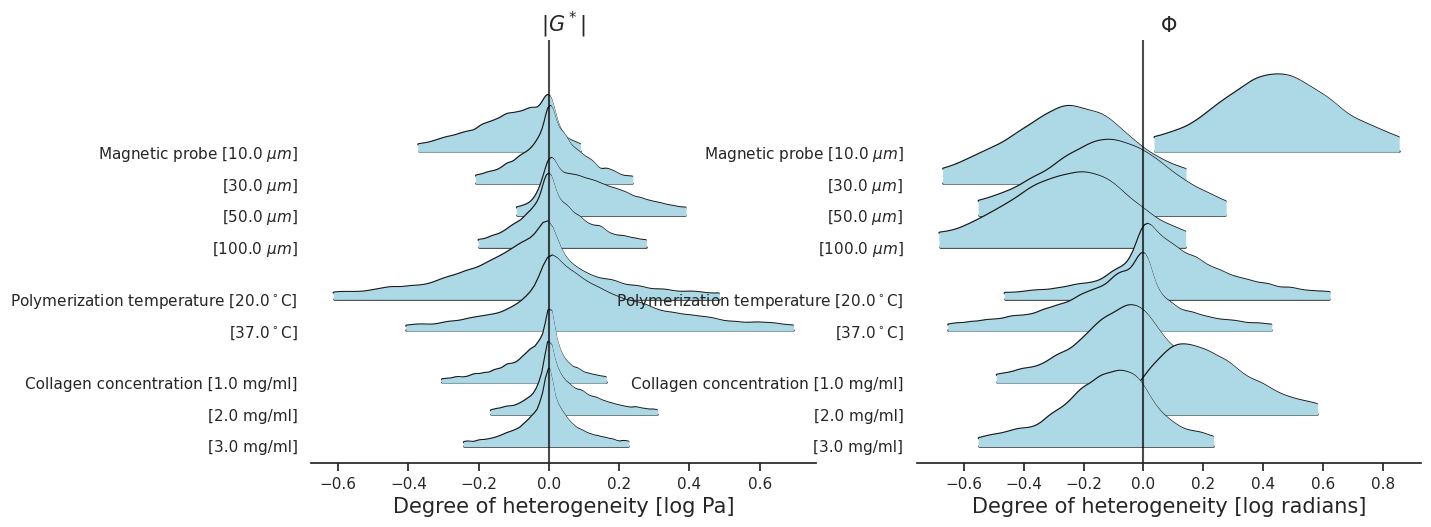

In [52]:
fig,ax = plt.subplots(1,2,figsize=(14.33,5.5))
ax[0] = az.plot_forest(trace,
                    var_names=['radius_sigma_effect','temperature_sigma_effect',
                               'concentration_sigma_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,kind='ridgeplot',
                    colors='lightblue',linewidth=1.8,
                    markersize=10,ax=ax[0],transform=lambda x:x)[0]

ax[1] = az.plot_forest(trace_phi,
                    var_names=['radius_sigma_effect','temperature_sigma_effect',
                               'concentration_sigma_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,kind='ridgeplot',
                    colors='lightblue',linewidth=1.8,
                    markersize=10,ax=ax[1],transform=lambda x:x)[0]
for a in ax.ravel():
    a.axvline(0,color='black',alpha=0.7)
    a.set_title('')

ax[0].set_xlabel('Degree of heterogeneity [log Pa]',fontsize=15)
ax[1].set_xlabel('Degree of heterogeneity [log radians]',fontsize=15)

ax[0].set_title(r'$|G^*|$',fontsize=15)
ax[1].set_title(r'$\Phi$',fontsize=15)

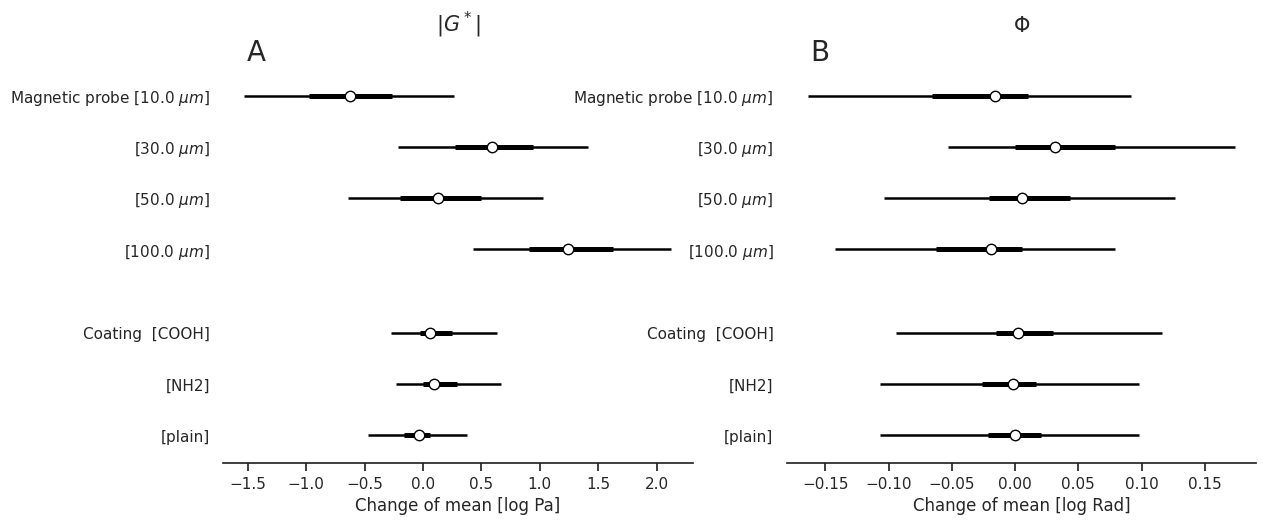

In [53]:
fig,ax = plt.subplots(1,2,figsize=(13.33,5.5))
ax[0] = az.plot_forest(trace,
                    var_names=['radius_effect','coating_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors='black',linewidth=1.8,
                    markersize=10,ax=ax[0],transform=lambda x: x)[0]

ax[1] = az.plot_forest(trace_phi,
                    var_names=['radius_effect','coating_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors='black',linewidth=1.8,
                    markersize=10,ax=ax[1],transform=lambda x:x)[0]
for a in ax.ravel():
    #a.axvline(0,color='black',alpha=0.1)
    a.set_title('')

ax[0].set_xlabel('Change of mean [log Pa]',fontsize=12)
ax[1].set_xlabel('Change of mean [log Rad]',fontsize=12)
ax[0].text(0.05, 0.95, 'A', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'B', transform=ax[1].transAxes,fontsize=20)
ax[0].set_title(r'$|G^*|$',fontsize=15)
ax[1].set_title(r'$\Phi$',fontsize=15)
fig.savefig(f'results/mean_effects.png',bbox_inches = 'tight',dpi=600)

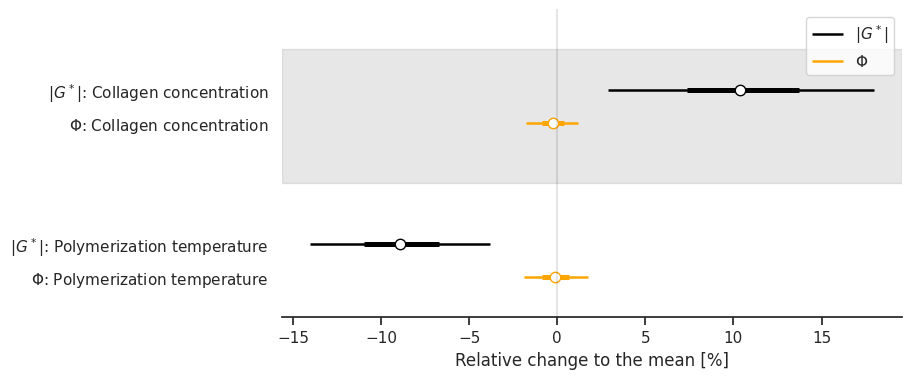

In [94]:
ax = az.plot_forest([trace,trace_phi],
                    var_names=['concentration_mu','temperature_mu'],
                    model_names = [r"$|G^*|$", r"$\Phi$"],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors=['black','orange'],linewidth=1.8,
                    markersize=10,
                    transform=lambda x:100*(np.exp(x)-1)/2.516299966770583,figsize=(8,4)) # to 1 unit

ax[0].axvline(0,color='black',alpha=0.1)
ax[0].set_title('')
ax[0].set_xlabel('Relative change to the mean [%]')
ax[0].get_legend().set_frame_on(True)
ax[0].legend([ax[0].collections[2],ax[0].collections[0]],[r"$|G^*|$", r"$\Phi$"])
plt.savefig(f'results/slope_effects.png',bbox_inches = 'tight',dpi=600)

/tmp/ipykernel_195/1844893623.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.boxplot(data=data,x='crosslinker',y='G_abs_norm',hue='size',ax=ax,palette=sns.color_palette('colorblind'))


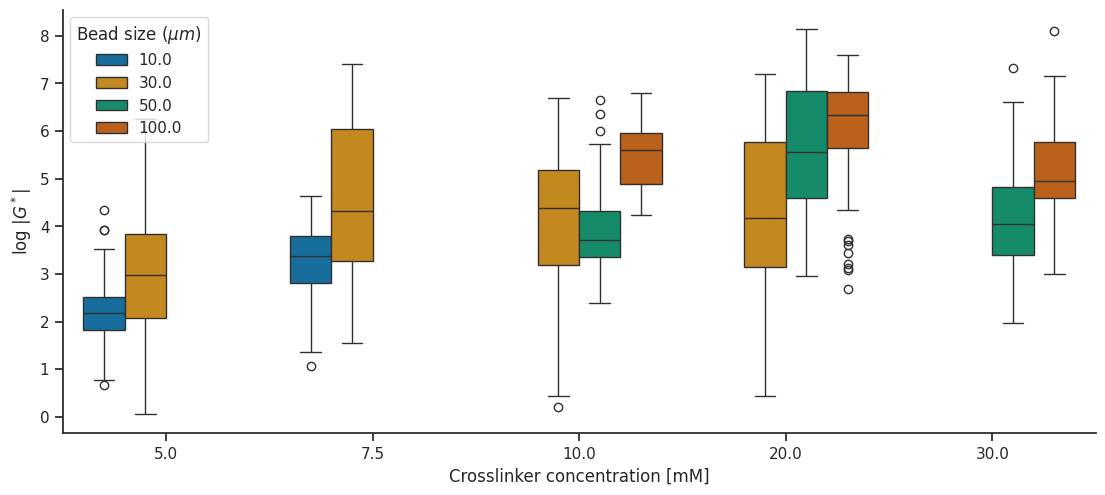

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(13.33,5.5))
ax = sns.boxplot(data=data,x='crosslinker',y='G_abs_norm',hue='size',ax=ax,palette=sns.color_palette('colorblind'))
ax.set_xlabel(xlabel)
ax.set_ylabel(r'log $|G^*|$')
ax.legend(title=r'Bead size ($\mu m$)',loc='upper left')
fig.savefig(f'results/bead_size.png',bbox_inches = 'tight',dpi=600)

/tmp/ipykernel_195/3482251327.py:37: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
/tmp/ipykernel_195/3482251327.py:42: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df2[(df2['material']=='alginate') & (df2['type']=='data')],


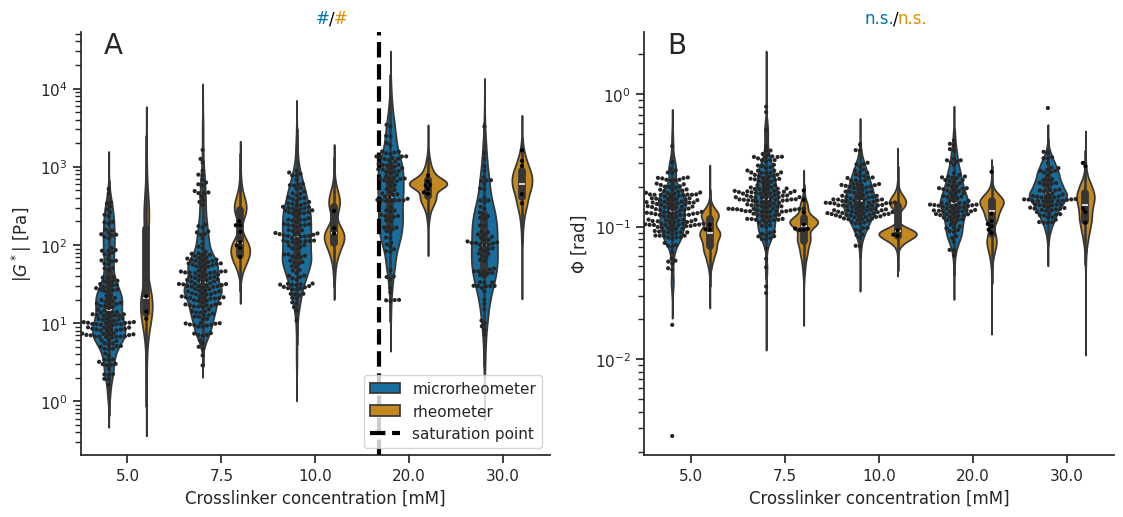

In [ ]:
sub_sample = 100
df1 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_raw,'G':np.exp(G+g_mean),'type':'data','method':'microrheometer',
                'material':data['type'].astype(pd.StringDtype()).reset_index()['type'],
                'temperature':data['temp'].values,'concentration':data['concentration'].values}),
            pd.DataFrame({'G': np.exp(einops.rearrange(np.array(samps.likelihood[::sub_sample]),'a b c -> (a b c)')+g_mean),'method':'microrheometer',
                'crosslinker':np.tile(crosslinker_raw,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                'type':'model','material':np.tile(data['type'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                'temperature':np.tile(data['temp'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                'concentration':np.tile(data['concentration'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2]))})])

df1 = pd.concat([df1,pd.concat([pd.DataFrame({'crosslinker':crosslinker_macro_raw,'G':np.exp(G_macro+g_mean),'type':'data','method':'rheometer',
                    'material':macro['type'].astype(pd.StringDtype()).reset_index()['type']}),
                pd.DataFrame({'G': np.exp(einops.rearrange(np.array(samps.likelihood_macro[::sub_sample]),'a b c -> (a b c)')+g_mean),
                    'method':'rheometer','crosslinker':np.tile(crosslinker_macro_raw,np.prod(states.sigma_alpha[::sub_sample].shape[:2])),
                    'type':'model','material':np.tile(macro['type'].values,np.prod(states.sigma_alpha[::sub_sample].shape[:2]))})])])

df2 = pd.concat([pd.DataFrame({'crosslinker':crosslinker_raw,'phi':np.exp(phi+phi_mean),'type':'data','method':'microrheometer',
                'material':data['type'].astype(pd.StringDtype()).reset_index()['type'],
                'temperature':data['temp'].values,'concentration':data['concentration'].values}),
            pd.DataFrame({'phi': np.exp(einops.rearrange(np.array(samps_phi.likelihood[::sub_sample]),'a b c -> (a b c)')+phi_mean),'method':'microrheometer',
                'crosslinker':np.tile(crosslinker_raw,np.prod(states_phi.sigma_alpha[::sub_sample].shape[:2])),
                'type':'model','material':np.tile(data['type'].values,np.prod(states_phi.sigma_alpha[::sub_sample].shape[:2])),
                'temperature':np.tile(data['temp'].values,np.prod(states_phi.sigma_alpha[::sub_sample].shape[:2])),
                'concentration':np.tile(data['concentration'].values,np.prod(states_phi.sigma_alpha[::sub_sample].shape[:2]))})])

df2 = pd.concat([df2,pd.concat([pd.DataFrame({'crosslinker':crosslinker_macro_raw,'phi':np.exp(phi_macro+phi_mean),'type':'data','method':'rheometer',
                    'material':macro['type'].astype(pd.StringDtype()).reset_index()['type']}),
                pd.DataFrame({'phi': np.exp(einops.rearrange(np.array(samps_phi.likelihood_macro[::10]),'a b c -> (a b c)')+phi_mean),
                    'method':'rheometer','crosslinker':np.tile(crosslinker_macro_raw,np.prod(states_phi.sigma_alpha[::10].shape[:2])),
                    'type':'model','material':np.tile(macro['type'].values,np.prod(states_phi.sigma_alpha[::10].shape[:2]))})])])

fig,ax = plt.subplots(1,2)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
sns.violinplot(data=df1[(df1['material']=='alginate')& (df1['type']=='model')],x='crosslinker',y='G',hue='method',
            ax=ax[0])
sns.swarmplot(data=df1[(df1['material']=='alginate') & (df1['type']=='data')],
            x='crosslinker',y='G',hue='method',ax=ax[0],dodge=True,color='black',s=3,legend=False)

sns.violinplot(data=df2[(df2['material']=='alginate') & (df2['type']=='model')],x='crosslinker',y='phi',
            hue='method',ax=ax[1])
sns.swarmplot(data=df2[(df2['material']=='alginate') & (df2['type']=='data')],
            x='crosslinker',y='phi',hue='method',ax=ax[1],dodge=True,color='black',s=3,legend=False)

@plt.FuncFormatter
def fake_log(x, pos):
    'The two args are the value and tick position'
    return r'${:.1f}$'.format(np.exp(x))

@plt.FuncFormatter
def fake_log2(x, pos):
    'The two args are the value and tick position'
    return r'${:.3f}$'.format(np.exp(x))

#ax[0].set_yticks(np.log([1,10,100,1000,10000]))
#ax[0].yaxis.set_major_formatter(fake_log)

ax[0].set_title('')
ax[1].set_title('')
ax[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)

#fig.suptitle('alginate')
ax[0].axvline(2+float((states.switchpoint.mean()+states.swtich_std.mean()*states.switch_z[...,0].mean())*c_std+c_mean-10)/10,
              linestyle='--',color='black',linewidth=3,label='saturation point')
#ax[0].text(0.47, 1.02, 'A',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, 'A', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'B', transform=ax[1].transAxes,fontsize=20)
ax[0].legend(loc='lower right')
#ax[0].set_ylim([1e-1,1e4])
#ax[1].set_ylim([1e-3,1e0])
ax[1].legend().remove()
ax[0].text(0.5, 1.02, '#',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[0].transAxes)
ax[0].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[0].transAxes)
ax[0].text(0.54, 1.02, '#',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[0].transAxes)

ax[1].text(0.47, 1.02, 'n.s.',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
ax[1].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[1].transAxes)
ax[1].text(0.54, 1.02, 'n.s.',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[1].transAxes)

#ax[1].set_yticks(np.log([1e-3,1e-2,1e-1,1,]))
#ax[1].yaxis.set_major_formatter(fake_log2)

fig.savefig(f'results/data_with_model_alginate.png',bbox_inches = 'tight',dpi=600)

/tmp/ipykernel_195/1821044157.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
/tmp/ipykernel_195/1821044157.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df2[(df2['material']=='ipn') & (df2['type']=='data')],


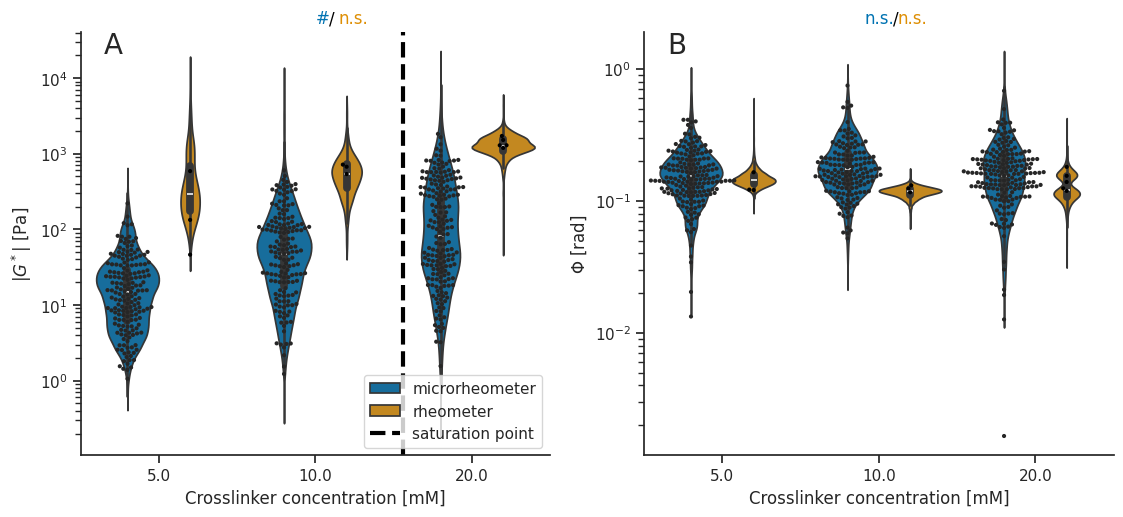

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
sns.violinplot(data=df1[(df1['material']=='ipn')& (df1['type']=='model')],x='crosslinker',y='G',hue='method',
            ax=ax[0])
sns.swarmplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data')],
            x='crosslinker',y='G',hue='method',ax=ax[0],dodge=True,color='black',s=3,legend=False)

sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model')],x='crosslinker',y='phi',
            hue='method',ax=ax[1])
sns.swarmplot(data=df2[(df2['material']=='ipn') & (df2['type']=='data')],
            x='crosslinker',y='phi',hue='method',ax=ax[1],dodge=True,color='black',s=3,legend=False)

ax[0].set_title('')
ax[1].set_title('')
ax[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)

ax[0].axvline(1+float((states.switchpoint.mean()+states.swtich_std.mean()*states.switch_z[...,1].mean())*c_std+c_mean-10)/10,
              linestyle='--',color='black',linewidth=3,label='saturation point')
#ax[0].text(0.47, 1.02, 'A',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, 'A', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'B', transform=ax[1].transAxes,fontsize=20)
ax[0].legend(loc='lower right')
#ax[0].set_ylim([1e-2,1e4])
#ax[1].set_ylim([1e-3,1e0])
ax[1].legend().remove()
ax[0].text(0.5, 1.02, '#',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[0].transAxes)
ax[0].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[0].transAxes)
ax[0].text(0.55, 1.02, 'n.s.',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[0].transAxes)

ax[1].text(0.47, 1.02, 'n.s.',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
ax[1].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[1].transAxes)
ax[1].text(0.54, 1.02, 'n.s.',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[1].transAxes)
fig.savefig(f'results/data_with_model_ipn.png',bbox_inches = 'tight',dpi=600)

/tmp/ipykernel_195/3514019635.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(data=df1[(df1['material']=='ipn')& (df1['type']=='model') & (df1['method']=='microrheometer')],x='crosslinker',y='G',hue='concentration',
/tmp/ipykernel_195/3514019635.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data') & (df1['method']=='microrheometer')],
/tmp/ipykernel_195/3514019635.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model') & (df2['method']=='microrheometer')],x='crosslinker',y='phi',
/tmp/ipykernel_195/3514019635.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `

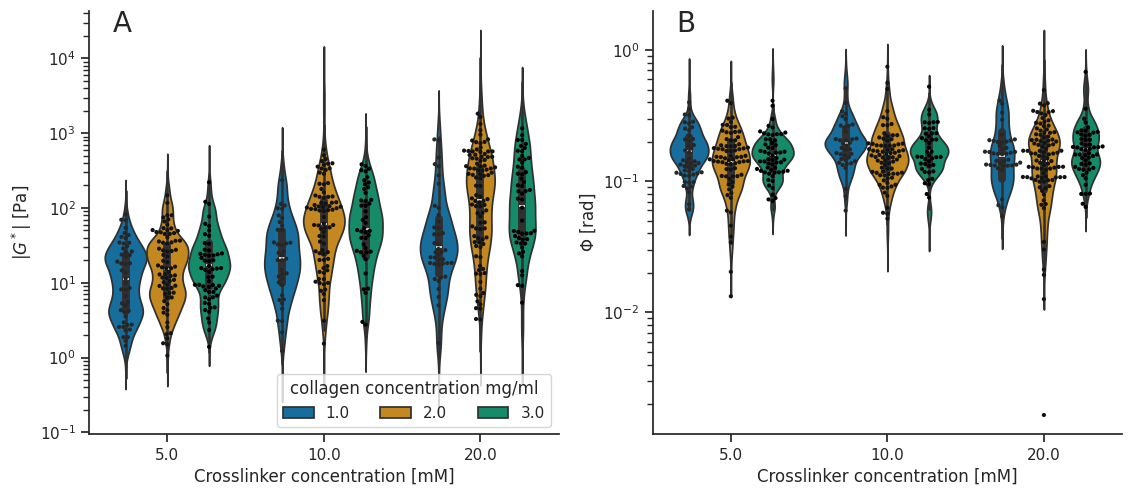

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
sns.violinplot(data=df1[(df1['material']=='ipn')& (df1['type']=='model') & (df1['method']=='microrheometer')],x='crosslinker',y='G',hue='concentration',
            ax=ax[0],palette=sns.color_palette('colorblind'))
sns.swarmplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data') & (df1['method']=='microrheometer')],
            x='crosslinker',y='G',hue='concentration',ax=ax[0],dodge=True,color='black',legend=False,s=3)

sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model') & (df2['method']=='microrheometer')],x='crosslinker',y='phi',
            hue='concentration',ax=ax[1],palette=sns.color_palette('colorblind'))
sns.swarmplot(data=df2[(df2['material']=='ipn') & (df2['type']=='data') & (df2['method']=='microrheometer')],
            x='crosslinker',y='phi',hue='concentration',ax=ax[1],dodge=True,color='black',legend=False,s=3)

ax[0].set_title('')
ax[1].set_title('')
ax[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)


#ax[0].text(0.47, 1.02, 'A',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, 'A', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'B', transform=ax[1].transAxes,fontsize=20)
ax[0].legend(loc='lower right',title='collagen concentration mg/ml',ncol=3)
#ax[0].set_ylim([1e-2,1e4])
#ax[1].set_ylim([1e-3,1e0])
ax[1].legend().remove()
# ax[0].text(0.5, 1.02, '#',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[0].transAxes)
# ax[0].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[0].transAxes)
# ax[0].text(0.55, 1.02, '#',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[0].transAxes)

# ax[1].text(0.47, 1.02, 'n.s.',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
# ax[1].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[1].transAxes)
# ax[1].text(0.54, 1.02, 'n.s.',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[1].transAxes)
fig.savefig(f'results/concentration_ipn.png',bbox_inches = 'tight',dpi=600)

In [ ]:
temps = pd.read_csv('data/revision_macro_collagen2_temperature20.csv')

In [ ]:
d_ipn = curve_datapoints_phi[:,1,:]-curve_datapoints_phi[:,-1,:]

In [ ]:
np.logical_and(d_ipn<phi_rope,d_ipn>-phi_rope).sum(axis=0)/d_ipn.shape[0]*100

array([14.88005997, 15.61094453, 16.49175412, 21.75787106, 17.37256372])

/tmp/ipykernel_195/1980542964.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df1[(df1['material']=='ipn')& (df1['type']=='model') & (df1['method']=='microrheometer')],x='crosslinker',
/tmp/ipykernel_195/1980542964.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data') & (df1['method']=='microrheometer')],
/tmp/ipykernel_195/1980542964.py:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model') & (df2['method']=='microrheometer')],x='crosslinker',y='phi',
/tmp/ipykernel_195/1980542964.py:12: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for

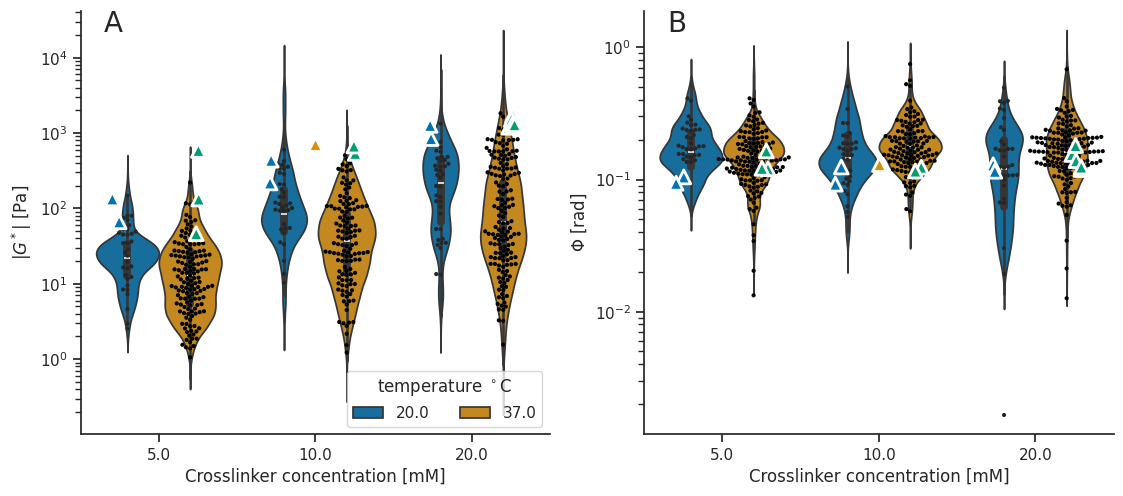

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
sns.violinplot(data=df1[(df1['material']=='ipn')& (df1['type']=='model') & (df1['method']=='microrheometer')],x='crosslinker',
               y='G',hue='temperature',
            ax=ax[0],palette=sns.color_palette('colorblind'))
sns.swarmplot(data=df1[(df1['material']=='ipn') & (df1['type']=='data') & (df1['method']=='microrheometer')],
            x='crosslinker',y='G',hue='temperature',ax=ax[0],dodge=True,color='black',legend=False,s=3)

sns.violinplot(data=df2[(df2['material']=='ipn') & (df2['type']=='model') & (df2['method']=='microrheometer')],x='crosslinker',y='phi',
            hue='temperature',ax=ax[1],palette=sns.color_palette('colorblind'))
sns.swarmplot(data=df2[(df2['material']=='ipn') & (df2['type']=='data') & (df2['method']=='microrheometer')],
            x='crosslinker',y='phi',hue='temperature',ax=ax[1],dodge=True,color='black',legend=False,s=3)

ax[0].set_title('')
ax[1].set_title('')
ax[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
combi = pd.concat([macro,temps])
combi['shear'] = combi['Complex Shear Modulus']
combi['phase'] = np.deg2rad(combi['Phase Shift Angle'])
sns.stripplot(data=combi[combi['type']=='ipn'],x='crosslinker',y='shear',hue='Temperature',ax=ax[0],
                palette=sns.color_palette('colorblind'),dodge=True,marker='^',s=10,edgecolor='white',legend=False,
                linewidth=2)
sns.stripplot(data=combi[combi['type']=='ipn'],x='crosslinker',y='phase',hue='Temperature',ax=ax[1],
                palette=sns.color_palette('colorblind'),dodge=True,marker='^',s=10,edgecolor='white',legend=False,
                linewidth=2)
#ax[0].text(0.47, 1.02, 'A',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, 'A', transform=ax[0].transAxes,fontsize=20)
ax[1].text(0.05, 0.95, 'B', transform=ax[1].transAxes,fontsize=20)
ax[0].legend(loc='lower right',title=r'temperature $^\circ$C',ncol=3)
#ax[0].set_ylim([1e-2,1e4])
#ax[1].set_ylim([1e-3,1e0])
ax[1].legend().remove()

# ax[0].text(0.5, 1.02, '#',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[0].transAxes)
# ax[0].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[0].transAxes)
# ax[0].text(0.55, 1.02, '#',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[0].transAxes)

# ax[1].text(0.47, 1.02, 'n.s.',color=sns.color_palette('colorblind')[0],fontsize=12,ha='left',transform=ax[1].transAxes)
# ax[1].text(0.53, 1.02, '/',color='black',fontsize=12,ha='left',transform=ax[1].transAxes)
# ax[1].text(0.54, 1.02, 'n.s.',color=sns.color_palette('colorblind')[1],fontsize=12,ha='left',transform=ax[1].transAxes)
fig.savefig(f'results/temperature_ipn.png',bbox_inches = 'tight',dpi=600)

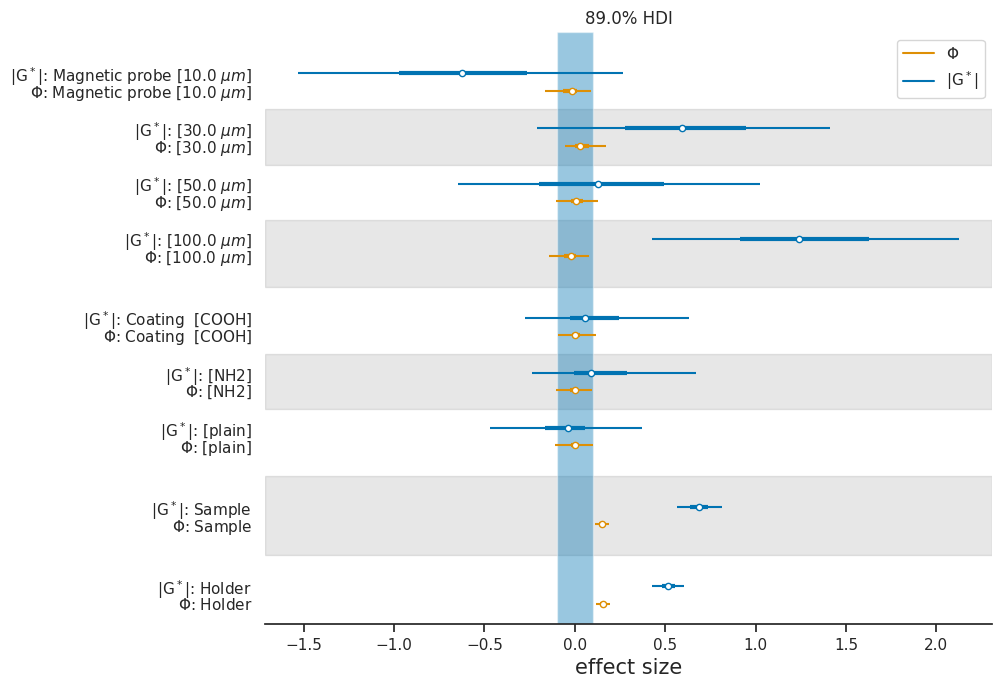

In [99]:
labeller = azl.MapLabeller(var_name_map={"radius_effect": "Magnetic probe ",
                                         "coating_effect": "Coating  ",
                                         "radius_sigma_effect": "Heterogeneity magnetic probe ",
                                         "temperature_sigma_effect": "Heterogeneity polymerization temperature ",
                                         "concentration_sigma_effect": "Heterogeneity collagen concentration ",
                                         "temperature_mu":"Polymerization temperature",
                                         "concentration_mu":"Collagen concentration",
                                         "holder_std": "Holder",
                                         "sample_std":"Sample"})


ax = az.plot_forest([trace,trace_phi],
                    model_names = [r"|G$^*$|", r"$\Phi$"],
                    var_names=['radius_effect','coating_effect','sample_std','holder_std'],
                    combined=True,labeller=labeller,hdi_prob=0.89,colors=sns.color_palette('colorblind')[:2],
                    figsize=(15,8))
ax[0].axvspan(-0.1,0.1,alpha=0.4)

ax[0].set_xlabel('effect size',fontsize=15)
fig = ax[0].figure
#ax[0].text(0.05, 0.95, 'B', transform=ax[0].transAxes,fontsize=20)
fig.savefig(f'results/effects_both.png',bbox_inches = 'tight',dpi=300)
fig.tight_layout()